<a href="https://colab.research.google.com/github/MinsooKwak/Project/blob/main/Project2_Final_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### kaggle import / Warning 제거


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [ ]:
!kaggle datasets download -d shivamb/tech-company-fundings-2020-onwards

In [ ]:
!ls

In [ ]:
!unzip '/content/tech-company-fundings-2020-onwards.zip'

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('tech_fundings.csv')

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [8]:
#!pip install pdpbox

### 고려해야 할 점 : 주의사항

- 타겟의 범주 비율이 True 82%로 불균형한 결과가 모델링 결과에 영향을 주었다.
- Logistic Regression model과 XG boost model을 사용하였는데, 모델 검증 결과가 같게 나왔다.
- 하이퍼파라미터를 조절해 보았지만 결과가 변함이 없으므로 모델 최종 학습을 진행했다. 
- 본 데이터는 2020년 이후의 데이터로 시간에 관련한 인사이트는 도출하지 못한다.
- 위도와 경도에 대한 데이터를 추가적으로 입력해주었고, 어느 지역이 더 많은 분포를 띄고 있는지 시각적으로 보여주는 것엔 한계가 있었다.
- 따라서 지역 별로 묶어주고 싶었으나 한계가 있었다(기각)
- High Cardinarity로 큰 범주화를 개인적으로 진행했음에 한계가 있을 수 있다.
- 모든 회사가 Website를 갖고 있으므로 모델링엔 불필요하여 제거해주었다.


##A. 데이터 파악

본 데이터는 2020년 이후 투자 받은 Tech company에 대한 정보를 담고 있다. 


- Company          : 회사
- Website          : 회사 홈페이지 
- Region           : 지역 (72개 지역) 
- Vertical (Field) : 투자 받은 영역 (143개 영역) 
- Funding Amount   : 투자 받은 금액(USD) 
- Funding Stage    : 투자 받은 단계 (어떤 투자인지)
- Funding Date     : 2020년 이후의 투자 받은 시점

In [9]:
df.shape 

(3575, 8)

In [10]:
print("Company        개수: ",df['Company'].nunique())
print("Website        개수: ",df['Website'].nunique())
print("Region         개수: ",df['Region'].nunique())
print("Vertical       개수: ",df['Vertical'].nunique())
print("Funding Stage  개수: ",df['Funding Stage'].nunique())

Company        개수:  3224
Website        개수:  3343
Region         개수:  72
Vertical       개수:  143
Funding Stage  개수:  22


- cardinarity를 확인하는 또 다른 방법
  - df.describe(exclude='number')

In [11]:
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Funding Date,3575,19,May-21,332
Funding Stage,3575,22,Series A,951
Region,3563,72,United States,2034
Vertical,3575,143,B2B Software,632
Funding Amount (USD),3575,969,10000000,105
Company,3575,3224,Thrasio,4
Website,3575,3343,https://humaninterest.com/,4


### Profiling (데이터 기초 파악)

In [12]:
#!pip install pandas-profiling==2.11.0 --upgrade

In [13]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# B. EDA 및 전처리 Data Wrangling

1>

In [14]:
df.head(2)

,df_index,Company,Website,Region,Vertical,Funding Amount (USD),Funding Stage,Funding Date
0,1,Internxt,https://internxt.com/,Spain,Blockchain,278940,Seed,Jan-20
1,2,Dockflow,https://dockflow.com,Belgium,Logistics,292244,Seed,Jan-20


## **1**. column 명 바꾸기

In [15]:
df.columns=['index','Company','Website','Region','Field','Funding Amount(USD)','Funding_stage','Funding_date']

In [16]:
df.head(1)

,index,Company,Website,Region,Field,Funding Amount(USD),Funding_stage,Funding_date
0,1,Internxt,https://internxt.com/,Spain,Blockchain,278940,Seed,Jan-20


## **2**. 결측치 있는 특성 확인

2-1) 가시적으로 드러나는 결측치 확인

In [17]:
[(x,df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()] 

[('Region', 12)]

2-2) 비가시적인 결측치 확인

In [18]:
df.dtypes

index                   int64
Company                object
Website                object
Region                 object
Field                  object
Funding Amount(USD)    object
Funding_stage          object
Funding_date           object
dtype: object

In [19]:
# Funding Amount가 현재 object형이지만, int로 바꿔줘야 한다. 

In [20]:
# df['Funding Amount (USD)']=pd.to_numeric(df['Funding Amount (USD)'])
'''ValueError: Unable to parse string "Unknown" at position 1262''' 

df.loc[[1262]]

,index,Company,Website,Region,Field,Funding Amount(USD),Funding_stage,Funding_date
1262,1263,Mobilewalla,https://www.mobilewalla.com/,United States,B2B Software,Unknown,Seed,Nov-20


In [21]:
df['Funding Amount(USD)']=pd.to_numeric(df['Funding Amount(USD)'],errors='coerce') # errors = 'coerce' -> 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환

In [22]:
df.dtypes

index                    int64
Company                 object
Website                 object
Region                  object
Field                   object
Funding Amount(USD)    float64
Funding_stage           object
Funding_date            object
dtype: object

In [23]:
df.isna().sum() # 형 변환을 시켜줬더니 드러나지 않았던 결측치가 드러남

index                   0
Company                 0
Website                 0
Region                 12
Field                   0
Funding Amount(USD)     9
Funding_stage           0
Funding_date            0
dtype: int64

결측치의 양이 많지 않으므로, imputation 대신 fillna()를 통해 처리하도록 하겠다.

In [24]:
pd.options.display.float_format = '{:.2f}'.format # 자연로그가 불편하므로 처리

### 전체 통계치

In [25]:
df.describe() # 전체 통계치

,index,Funding Amount(USD)
count,3575.00,3566.00
mean,1788.00,57560141.00
std,1032.16,298197613.73
min,1.00,40000.00
25%,894.50,5000000.00
50%,1788.00,15496301.50
75%,2681.50,50000000.00
max,3575.00,16600000000.00


In [26]:
mean_Funding_Amount = df['Funding Amount(USD)'].mean()

In [27]:
# 통계치 중 mean값을 사용하여 Funding Amount(USD)의 결측치를 채우겠다.
df['Funding Amount(USD)']=df['Funding Amount(USD)'].fillna(mean_Funding_Amount) #결측치 처리

In [28]:
df.isna().sum()

index                   0
Company                 0
Website                 0
Region                 12
Field                   0
Funding Amount(USD)     0
Funding_stage           0
Funding_date            0
dtype: int64

## **3**. 전처리

In [29]:
df['Funding_date'].unique()

array(['Jan-20', 'Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20',
       'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Jan-21', 'Feb-21',
       'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21',
       'Sep-21'], dtype=object)

In [30]:
def cleanword(string):
  return string.replace('-','')

df['Funding_date']=df['Funding_date'].apply(cleanword)

In [31]:
df.head(2)

,index,Company,Website,Region,Field,Funding Amount(USD),Funding_stage,Funding_date
0,1,Internxt,https://internxt.com/,Spain,Blockchain,278940.00,Seed,Jan20
1,2,Dockflow,https://dockflow.com,Belgium,Logistics,292244.00,Seed,Jan20


In [32]:
df['Funding Amount(USD)']=df['Funding Amount(USD)'].astype(int)
df.head(2)

,index,Company,Website,Region,Field,Funding Amount(USD),Funding_stage,Funding_date
0,1,Internxt,https://internxt.com/,Spain,Blockchain,278940,Seed,Jan20
1,2,Dockflow,https://dockflow.com,Belgium,Logistics,292244,Seed,Jan20


## **4**. 추가 DataPreprocessing (전처리) / Feature engineering 

### 4-1) Website 사용 여부 파악

In [33]:
df['Website'].isna().sum()

0

투자 받은 모든 Company가 website를 갖고 있으므로, 이 특성을 사용하는 것은 부적합하다고 판단 --> 제거

In [34]:
def engineer_features(X):

    # pandas.DataFrame.copy()
    X = X.copy()

    ## 사용하지 않을 특성을 삭제합니다.
    X = X.drop(['Website'],axis=1)

    return X

df = engineer_features(df)

In [35]:
df.head(2)

,index,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date
0,1,Internxt,Spain,Blockchain,278940,Seed,Jan20
1,2,Dockflow,Belgium,Logistics,292244,Seed,Jan20


### 4-2) Region

-> clustering이 필요할 것으로 보인다. (High possibility)
 - 국가가 71개가 있다. 

In [36]:
df['Region'].unique()

array(['Spain', 'Belgium', 'France', 'United States', 'United Kingdom',
       'Turkey', 'Australia', 'Japan', 'Israel', 'Poland', 'Switzerland',
       'Canada', 'India', 'Germany', 'Austria', 'Finland', 'South Korea',
       'Sweden', 'Indonesia', 'China', 'Lithuania', 'Nigeria',
       'Singapore', 'Denmark', 'Ukraine', 'United Arab Emirates',
       'Hong Kong', 'Estonia', 'Ireland', 'Greece', 'Cyprus',
       'The Netherlands', 'Italy', 'Luxembourg', 'Mexico', 'South Africa',
       'Bangladesh', 'Norway', 'Thailand', 'Brazil', 'Colombia',
       'Portugal', 'Cambodia', 'Iceland', nan, 'Taiwan', 'Philippines',
       'Malaysia', 'Armenia', 'Egypt', 'Ghana', 'Saudi Arabia',
       'Pakistan', 'Belize', 'Czech Republic',
       'Slovakia (Slovak Republic)', 'Latvia', 'Gibraltar',
       'Liechtenstein', 'Hungary', 'Argentina', 'Malta', 'New Zealand',
       'Romania', 'Chile', 'Ecuador', 'Serbia', 'Kenya', 'Peru',
       'Vietnam', 'Unkown', 'Isle of Man', 'Senegal'], dtype=object)

In [37]:
df.Region.nunique()

72

In [38]:
pd.DataFrame(df['Region'].value_counts()).T

,United States,United Kingdom,India,Canada,Germany,France,Israel,Australia,Singapore,Spain,The Netherlands,Switzerland,Sweden,Finland,Nigeria,Brazil,Ireland,Denmark,Indonesia,Belgium,Hong Kong,Estonia,Austria,Japan,Mexico,China,Poland,United Arab Emirates,Saudi Arabia,Turkey,Argentina,Italy,South Korea,Malaysia,Norway,Chile,South Africa,Lithuania,Colombia,Pakistan,Egypt,New Zealand,Portugal,Czech Republic,Philippines,Unkown,Taiwan,Cyprus,Thailand,Ukraine,Serbia,Iceland,Hungary,Kenya,Bangladesh,Liechtenstein,Armenia,Senegal,Peru,Isle of Man,Slovakia (Slovak Republic),Cambodia,Latvia,Belize,Vietnam,Greece,Romania,Gibraltar,Malta,Ghana,Luxembourg,Ecuador
Region,2034,319,156,111,101,96,93,53,50,42,35,30,28,27,24,24,23,22,22,21,18,14,13,13,13,11,11,10,10,9,8,8,7,6,6,6,6,6,6,5,5,5,5,4,4,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [39]:
World_count_sort = df.Region.value_counts().sort_values(ascending=False) #투자 받은 지역들을 집계해 저장해줌

### **+** 국가들에 대한 위도, 경도 정보

Region에 대한 Feature engineering : 위도, 경도에 대한 정보를 추가적으로 입력해주었다. 

In [40]:
world_location= pd.DataFrame({'Region':['Spain', 'Belgium', 'France', 'United States', 'United Kingdom','Turkey', 'Australia', 'Japan', 'Israel', 'Poland', 'Switzerland', 'Canada', 
                                        'India', 'Germany', 'Austria', 'Finland', 'South Korea', 'Sweden', 'Indonesia', 'China', 'Lithuania', 'Nigeria','Singapore', 'Denmark', 'Ukraine', 
                                        'United Arab Emirates','Hong Kong', 'Estonia', 'Ireland', 'Greece', 'Cyprus','The Netherlands', 'Italy', 'Luxembourg', 'Mexico', 'South Africa',
                                       'Bangladesh', 'Norway', 'Thailand', 'Brazil', 'Colombia','Portugal', 'Cambodia', 'Iceland', 'Taiwan', 'Philippines','Malaysia', 'Armenia', 'Egypt', 
                                        'Ghana', 'Saudi Arabia','Pakistan', 'Belize', 'Czech Republic', 'Slovakia (Slovak Republic)', 'Latvia', 'Gibraltar','Liechtenstein', 'Hungary', 'Argentina', 
                                        'Malta', 'New Zealand','Romania', 'Chile', 'Ecuador', 'Serbia', 'Kenya', 'Peru', 'Vietnam', 'Isle of Man', 'Senegal'],
                             'latitude':[ -3.74922, 50.503887, 48.8032, 37.09024, 51.51333, 38.963745, -35.30806, 36.204824, 31.7857, 51.919438, -26.3, 45.423494,
                                           28.635308, 52.5234051, -35.3069444, 64, 35.907757, 59.6167, -6.211544 ,35.86166, 55.169438, 9.081999, 1.2894066, 56.26392, 48.379433,
                                           24,22.4060834, 59, 53.3331,39.074208, 35, 52.132633, 41.87194, 49.75, 23.634501, -25.7460186,
                                           23.68, 59.9138204 ,13.750000, -23.533300,4.600000, 39.399872, 4.600000, 65, 23.7,14.5833333, 4.210484, 40, 26.820553,
                                           7.946527, 23.885942, 30.37, 17.15, 50.065756, 48.15, 56.88, -75.84806999999999, 47.16, 47.162494,-34,
                                           35.5,-41.28648,44.430481,-33.450000,-1.831239,43.57,1,-9.189967,21.0241667,54.15,14.497401],
                             'longtitude':[40.463667, 4.469936, 2.3511, -95.712891, -0.088947, 35.243322, 149.12444, 138.252924, 35.2007, 19.145136, 31.3, -75.697933,
                                        77.22496, 13.4113999,149.1242972,26,127.766922,16.55,106.845172,104.195397,23.881275,8.675277,103.8499619,9.501785,31.16558,
                                        54,114.1201536, 26, -6.2489,21.824312, 33, 5.291266, 12.56738,  6.1667, -102.552784, 28.1871204,
                                        90.35, 10.7387413, 100.516700,-46.616700,-74.083300, -8.224454,-74.083300, -18, 120.96,120.9666667,101.975766, 45, 30.802498,
                                        -1.023194, 45.079162, 69.34, -88.45, 14.453939, 17.1167,  24.6, 5.57865, 9.32, 19.503304,-64,
                                        14.35,174.776217, 26.12298, -70.666700,-78.183406, 21.41,38, -75.015152,105.8411111,4.30,-14.452362]
                              })
world_location

,Region,latitude,longtitude
0,Spain,-3.75,40.46
1,Belgium,50.50,4.47
2,France,48.80,2.35
3,United States,37.09,-95.71
4,United Kingdom,51.51,-0.09
...,...,...,...
66,Kenya,1.00,38.00
67,Peru,-9.19,-75.02
68,Vietnam,21.02,105.84
69,Isle of Man,54.15,4.30


In [41]:
df = pd.merge(df, world_location, on='Region')
df

,index,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude
0,1,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46
1,196,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46
2,300,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46
3,313,ANYVERSE,Spain,Autonomous Vehicles,3000000,Series A,Apr20,-3.75,40.46
4,384,Bloobirds,Spain,B2B Software,3000000,Series A,May20,-3.75,40.46
...,...,...,...,...,...,...,...,...,...
3555,3081,MarketForce,Kenya,B2B Software,100000,Seed,Aug21,1.00,38.00
3556,3167,Crehana,Peru,Education,70000000,Series B,Aug21,-9.19,-75.02
3557,3218,Tiki Corporation,Vietnam,Marketplace,20000000,Series E,Aug21,21.02,105.84
3558,3326,Bloktopia,Isle of Man,Blockchain,4200000,Seed,Sep21,54.15,4.30


In [42]:
df.isna().sum()

index                  0
Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
dtype: int64

In [43]:
import folium

map = folium.Map(location=[35.907757, 127.766922],   # 지도의 중심 위치(위도, 경도) #우리나라임
				 zoom_start=2,                 # zoom_start 
                 tiles='Stamen Toner') # Stamen Toner, Stamen Terrain, ...

for a in world_location.index:
    latitude = world_location.loc[a,"latitude"]
    longtitude = world_location.loc[a,"longtitude"]
    tooltip = "invest"
    folium.Marker([latitude, longtitude], popup = 'invested!',tooltip =tooltip).add_to(map)   

map

### **+** united state 재확인

In [44]:
united_state =df[df['Region'].str.contains('United States')]
united_state

,index,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude
159,4,Buck.ai,United States,Artificial Intelligence,300000,Seed,Jan20,37.09,-95.71
160,7,Seatrec,United States,Marine Technology,970000,Seed,Jan20,37.09,-95.71
161,8,BeeCanvas,United States,B2B Software,1000000,Seed,Jan20,37.09,-95.71
162,9,SmartKarrot,United States,B2B Software,1000000,Angel,Jan20,37.09,-95.71
163,11,Fundraise Up,United States,B2B Software,1250000,Seed,Jan20,37.09,-95.71
...,...,...,...,...,...,...,...,...,...
2188,3560,Locus Robotics,United States,Robotics,50000000,Series E,Sep21,37.09,-95.71
2189,3561,Discord,United States,Social Network,500000000,Series H,Sep21,37.09,-95.71
2190,3563,Qwilt,United States,Telecommunications,70000000,Series E,Sep21,37.09,-95.71
2191,3570,SmarterTravel,United States,Travel,9500000,Series B,Sep21,37.09,-95.71


united state가 높은 비중을 갖고 있음을 확인할 수 있다. 

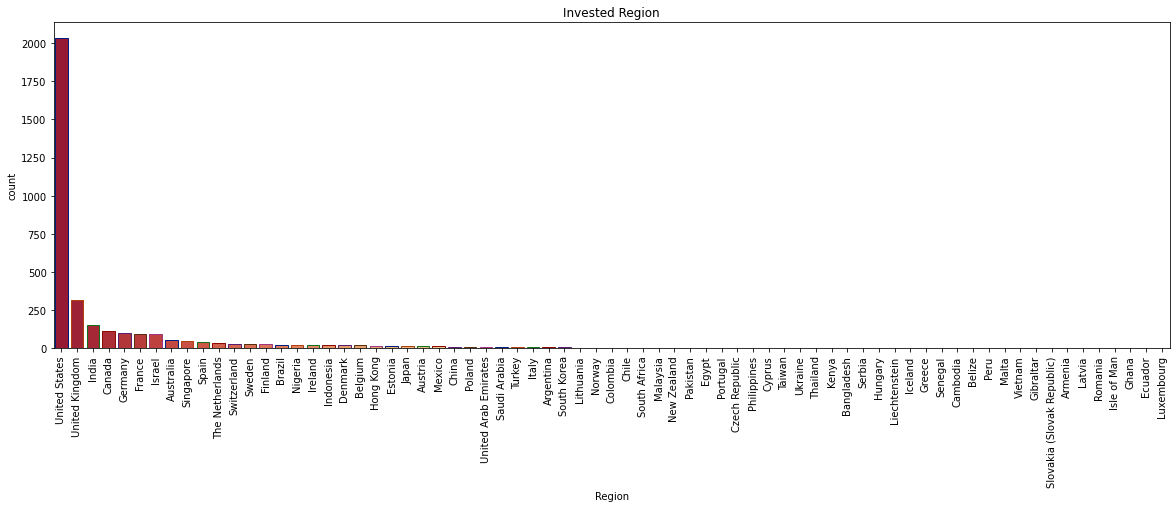

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(20,6))
sns.countplot('Region', data=df, palette='RdYlGn',
              edgecolor=sns.color_palette('dark',7),
              order=df['Region'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Invested Region')
plt.show()

In [46]:
'''지역별로 분류를 할지 말지가 고민했으나, 미국이 가장 많은 투자를 받고 있다는 인사이트를 얻는 것에서 마무리하도록 하겠다. '''

'지역별로 분류를 할지 말지가 고민했으나, 미국이 가장 많은 투자를 받고 있다는 인사이트를 얻는 것에서 마무리하도록 하겠다. '

### 4-3) Field (Vertical)
- High Cardinarity를 갖고 있음
- category화 해야겠다.

In [47]:
pd.DataFrame(df['Field'].value_counts()) # Field 확인 

,Field
B2B Software,632
Cloud Computing,285
Artificial Intelligence,283
Finance,254
Blockchain,235
...,...
Consumer Electronics,1
Broadcasting,1
Video Software,1
POS,1


In [48]:
df['Field'].unique()  #Vertical -->Field

array(['Blockchain', 'B2B Software', 'Autonomous Vehicles',
       'Air Transportation', 'Cyber Security', 'Wellness', 'Education',
       'Finance', 'Recruiting', 'Cloud Computing', 'Marketplace',
       'Artificial Intelligence', 'Logistics', 'Aerospace', 'Health Care',
       'E-Commerce Store', 'Gaming', 'Human Resources',
       'Financial Services, FinTech', 'Biotechnology', 'Enterprise',
       'FinTech', 'Cloud Security', 'Electric Vehicle', 'Social Network',
       'Food and Beverage', 'Developer APIs', 'Travel', 'Video',
       'Professional Networking', 'Co-Living', 'Audio Software', 'Legal',
       'Building Construction', 'Marketing', 'Neuroscience', 'Wearables',
       'E-Commerce Platforms', 'Insurance', 'Transportation', 'Drones',
       'Materials', 'E-Commerce Software', 'Investing', 'Media',
       'Quantum Computing', 'Marine Technology', 'Home Renovation',
       'CoWorking', 'Real Estate', 'Hardware', 'Legal Tech', 'Consumer',
       'Augmented Reality', 'Computer

### **-** Field 큰 범주로 카테고리화 

In [49]:
#카테고리화 List 

In [50]:
# 기술과 관련된 Category
blockchain_cat = ['Blockchain','Blockhain']
data_cat = ['Big Data','Data','Data Center']
ai_cat=['Artificial Intelligence','Computer Vision','Virtual Reality','Robotics','Machine Learning','Automotive','Augmented Reality','Drones','POS']
computing_cat=['B2B Software','Cloud Computing','Audio Software','E-Commerce Software','Hardware','Web Development','Software','Enterprise Software','Design Software','E-commerce Software','B2B Softare','Quantum Computing','Video Software',
               'Developer APIs','Developer Tools','Cloud Management','Cloud Data Services','Web Browsers','Sensors','Sensor','Mechanical Engineering']
security_cat =['Cyber Security','Cloud Security''Clouyd Security','Security']
networking_cat =['Social Network','Professional Networking','Telecommunications','Communities','Developer Platform','Community']
cat_3D =['3D Technology','3D','3D Printing']


# Business 또는 금융쪽 Category
Fianace_cat = ['Finance','Financial Services', 'FinTech','FinTech','Insurance','Investing','Insureance','InsurTech','Venture Capital','Accounting','Real Estate','Analytics']
business_cat= ['Recruiting','Marketplace','Human Resources','Enterprise','E-Commerce Store','E-Commerce','Marketing','E-Commerce Platforms','Consumer','Employee Benefits','E-Commerce','Sales','Human resources','Business Intelligence',
               'Supply Chain Management','Market Research','Consumer Electronics','E-Commerce Platform','Employee Training','Business Travel','Corporate Training','CoWorking','Advertising', 'Events','Product Design']


# Bio 및 Wellbeing Category
bio_cat = ['Biotechnology','Hospitality','Medical Device','MedTech','Neuroscience']
living_cat =['Food and Beverage','Co-Living','Home Renovation','Food & Beverage', 'Fashion','Recycling','Baby','Pets','Food Delivery','Wearables','Mapping']
wellbing_cat=['Identity Management','Wellness','Health Care','Fitness','Personal Health','Nutraceutical','Wellbeing']
entertain_cat = ['Gaming','Travel','Music','Video Tech','Animation','Audio','Audio Tech','Media','Video','Podcasting','Broadcasting']
life_base_environ_cat =['Agriculture','Marine Technology']


# Infra 및 Vehicle Category
vehicle_cat = ['Autonomous Vehicles','Air Transportation','Aerospace','Electric Vehicle','Transportation','Electric Vehicles','Autonomous Driving']
infra_cat = ['Education','Legal','Legal Tech','Knowledge Management','Fraud Detection','Charity']
infra_resource_cat =['Building Construction','Materials','Manufacturing','Construction','Warehousing','Packaging','Electronics']
environment_cat =['CleanTech','Energy','Clean Energy']

# extra 
extra_cat =['Cannabis']

In [51]:
# 큰 범주로 묶어주기
Tech = blockchain_cat+ data_cat+ ai_cat+ computing_cat+ security_cat+ networking_cat+ cat_3D
Busi = Fianace_cat+ business_cat
Health = bio_cat+ living_cat+ wellbing_cat+ entertain_cat+ life_base_environ_cat
Infra_Vech = vehicle_cat+ infra_cat+ infra_resource_cat+ environment_cat
extra = extra_cat

In [52]:
abc = [] #리스트 생성 
for row in df['Field'] : # 'Field'의 값을 얻어옴 
  if row in(Tech):
    abc.append('Tech') # Tech 범주에 속하면 Category에 Tech를 추가
  elif row in(Busi):
    abc.append('Business') # Busi 범주에 속하면 Category에 Business를 추가
  elif row in(Health):
    abc.append('Health') # Health 범주에 속하면 Category에 Health를 추가
  elif row in(Infra_Vech):
    abc.append('Infra_vehicle') # Infra_Vech 범주에 속하면 Category에 Infra_vehicle를 추가
  else : 
    abc.append('Extra') 

df['Category'] = abc # Category열에 순차대로 원소를 대입

In [53]:
df

,index,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
0,1,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech
1,196,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech
2,300,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46,Tech
3,313,ANYVERSE,Spain,Autonomous Vehicles,3000000,Series A,Apr20,-3.75,40.46,Infra_vehicle
4,384,Bloobirds,Spain,B2B Software,3000000,Series A,May20,-3.75,40.46,Tech
...,...,...,...,...,...,...,...,...,...,...
3555,3081,MarketForce,Kenya,B2B Software,100000,Seed,Aug21,1.00,38.00,Tech
3556,3167,Crehana,Peru,Education,70000000,Series B,Aug21,-9.19,-75.02,Infra_vehicle
3557,3218,Tiki Corporation,Vietnam,Marketplace,20000000,Series E,Aug21,21.02,105.84,Business
3558,3326,Bloktopia,Isle of Man,Blockchain,4200000,Seed,Sep21,54.15,4.30,Tech


### 4-4) 사용하지 않을 특성 제거

In [54]:
def drop_index(X):

    # pandas.DataFrame.copy()
    X = X.copy()

    ## 사용하지 않을 특성을 삭제합니다.
    X = X.drop(['index'],axis=1)

    return X

df = drop_index(df)

In [55]:
def engineer_features2(X):

    # pandas.DataFrame.copy()
    X = X.copy()

    ## 사용하지 않을 특성을 삭제합니다.
    X = X.drop(['Field'],axis=1)

    return X

df2 = engineer_features2(df)

In [56]:
df2.head(4)

,Company,Region,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
0,Internxt,Spain,278940,Seed,Jan20,-3.75,40.46,Tech
1,Internxt,Spain,268000,Seed,Mar20,-3.75,40.46,Tech
2,Factorial,Spain,16000000,Series A,Apr20,-3.75,40.46,Tech
3,ANYVERSE,Spain,3000000,Series A,Apr20,-3.75,40.46,Infra_vehicle


이제 Field의 Category별로 OneHotEncoding을 진행할 수 있다.

### **+** 카테고리 범주 확인 및 비율



In [57]:
df2.Category.value_counts()

Tech             1855
Business          892
Health            478
Infra_vehicle     259
Extra              76
Name: Category, dtype: int64

In [58]:
df2.Category.value_counts(normalize=True,ascending=False) # Category 영역의 비율

Tech            0.52
Business        0.25
Health          0.13
Infra_vehicle   0.07
Extra           0.02
Name: Category, dtype: float64

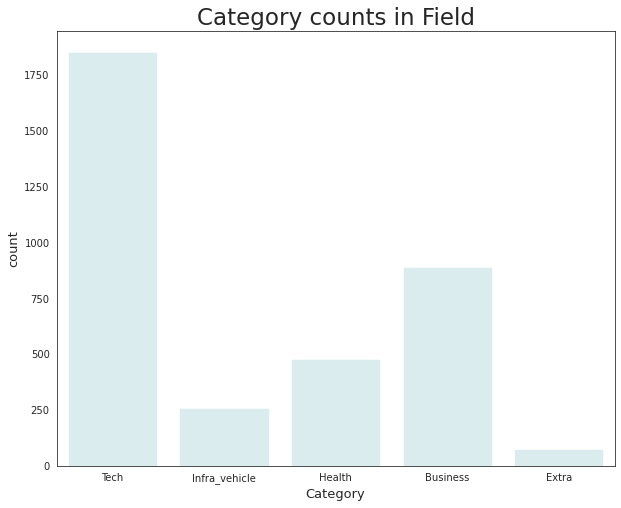

In [59]:
sns.set_style('white')
fig= plt.figure(figsize=(10,8))
area2 = fig.add_subplot(1,1,1)
area2.set_title('Category counts in Field',fontsize=23)
area2.set_xlabel('Category',fontsize=13)
area2.set_ylabel('Count',fontsize=13)
sns.countplot(x=df2['Category'],data=df2, color='#b0e0e6',alpha=0.5,ax=area2)



> 카테고리별 묶어주기



In [60]:
grouped_category = df.groupby('Category')

Tech_grouped = grouped_category.get_group('Tech')
Infra_vehicle_grouped = grouped_category.get_group('Infra_vehicle')
Health_grouped = grouped_category.get_group('Health')
Business_grouped = grouped_category.get_group('Business')
Extra_grouped = grouped_category.get_group('Extra')



*   Tech 기업이 가장 높은 비율을 차지하고 있으므로, Tech 기업에 대해 더 살펴보겠다.





> Category Tech에 속한 기업들에 대한 데이터프레임을 추가적으로 형성해줌



In [61]:
Tech_df = Tech_grouped.reset_index()
Tech_df.head(2)

,index,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
0,0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech
1,1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech


In [62]:
Tech_df = Tech_df[['Company', 'Region','Field','Funding_stage', 'Category','Funding Amount(USD)']]
Tech_df

,Company,Region,Field,Funding_stage,Category,Funding Amount(USD)
0,Internxt,Spain,Blockchain,Seed,Tech,278940
1,Internxt,Spain,Blockchain,Seed,Tech,268000
2,Factorial,Spain,B2B Software,Series A,Tech,16000000
3,Bloobirds,Spain,B2B Software,Series A,Tech,3000000
4,CounterCraft,Spain,Cyber Security,Seed,Tech,5000000
...,...,...,...,...,...,...
1850,Fracttal,Chile,Cloud Computing,Series B,Tech,5300000
1851,Tenderly,Serbia,Blockchain,Series A,Tech,15330000
1852,Tenderly,Serbia,Blockchain,Series A,Tech,15300000
1853,MarketForce,Kenya,B2B Software,Seed,Tech,100000


Tech 분야 Field(Verticle) Top 10

In [63]:
# Tech 분야 Top10
Tech_top10 = Tech_df.Field.value_counts().reset_index().head(10)
Tech_top10

,index,Field
0,B2B Software,632
1,Cloud Computing,285
2,Artificial Intelligence,283
3,Blockchain,235
4,Cyber Security,147
5,E-Commerce Software,50
6,Robotics,29
7,Social Network,26
8,Developer Tools,24
9,Community,20


Tech 분야 Field(Verticle) Top10에 대한 비율

In [64]:
Tech_df['Field'].value_counts(normalize=True, ascending=False).head(10)

B2B Software              0.34
Cloud Computing           0.15
Artificial Intelligence   0.15
Blockchain                0.13
Cyber Security            0.08
E-Commerce Software       0.03
Robotics                  0.02
Social Network            0.01
Developer Tools           0.01
Community                 0.01
Name: Field, dtype: float64

Text(0, 0.5, 'Count')

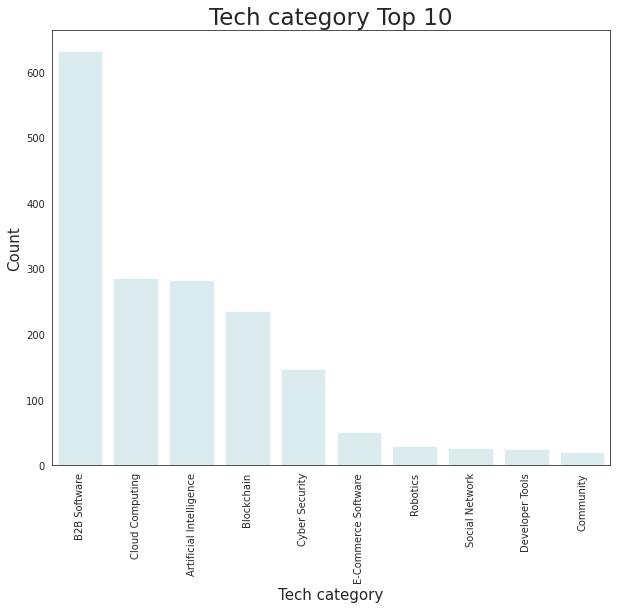

In [65]:
sns.set_style('white')
fig= plt.figure(figsize=(10,8))
fig.add_subplot(1,1,1)
ax=sns.barplot(x=Tech_top10['index'],y=Tech_top10['Field'],data=Tech_top10,alpha=0.5,color='#b0e0e6')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Tech category Top 10',fontsize=23)
ax.set_xlabel('Tech category',fontsize=15)
ax.set_ylabel('Count',fontsize=15)

Tech 분야에 있는 기업들이 위치한 국가 Top 10

In [66]:
# Tech 분야 Region Top10
Tech_R_top10 = Tech_df.Region.value_counts().reset_index().head(10)
Tech_R_top10

,index,Region
0,United States,1130
1,United Kingdom,153
2,Israel,75
3,Canada,65
4,Germany,53
5,France,46
6,India,37
7,Singapore,27
8,Australia,26
9,Switzerland,22


In [67]:
Tech_df['Region'].value_counts(normalize=True, ascending=False).head(10)

United States    0.61
United Kingdom   0.08
Israel           0.04
Canada           0.04
Germany          0.03
France           0.02
India            0.02
Singapore        0.01
Australia        0.01
Switzerland      0.01
Name: Region, dtype: float64

Text(0, 0.5, 'Count')

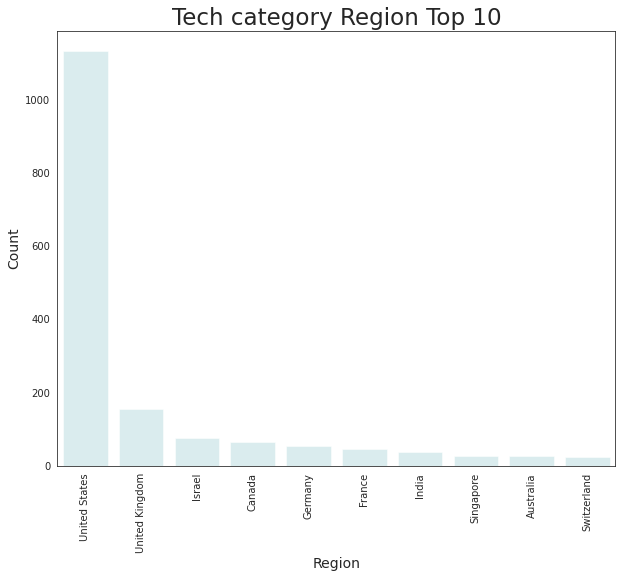

In [68]:
sns.set_style('white')
fig= plt.figure(figsize=(10,8))
fig.add_subplot(1,1,1)
ax=sns.barplot(x=Tech_R_top10['index'],y=Tech_R_top10['Region'],data=Tech_R_top10,alpha=0.5,color='#b0e0e6')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Tech category Region Top 10',fontsize=23)
ax.set_xlabel('Region',fontsize=14)
ax.set_ylabel('Count',fontsize=14)

### 4-5) Funding Stage

In [69]:
df.Funding_stage.nunique()

22

In [70]:
df['Funding_stage'].unique()

array(['Seed', 'Series A', 'Series B', 'Series C', 'Series G', 'Series F',
       'Series D', 'Pre-Seed', 'Angel', 'Undisclosed', 'Unknown',
       'Series E', 'Debt Financing', 'ICO', 'Private Equity', 'Grant',
       'Series H', 'Funding', 'Growth', 'Crowdfunding',
       'Initial Coin Offering', 'Unkown'], dtype=object)

Pre-seed funding:  
- the earliest stage of funding 
- so early that many people don’t include it in the cycle of equity funding
  - founders themselves
  - their families, friends and family, 
  - angel investor or an incubator

(Ealry Stage Startup)
Series A round: ($2 million to $15 million)
- startups are expected to have a plan for developing a business model, 
- even if they haven’t proven it yet. 
- They’re also expected to use the money raised to increase revenue
  - usually led by one investor, who anchors the round
  - Series A funding usually comes from venture capital firms
  - more companies are using equity crowdfunding for their Series A
  - According to the firm CB Insights, **only 46 percent of seed funded companies **will raise another round. 

(Late Stage Startup)
Series B round : ($7 million and $10 million) 
                Companies can expect a valuation between $30 million and $60 million.
- already found their product/market fit 
- needs help expanding
- may also attract the interest of venture capital firms that invest in late-stage startups

(Final push to prepare company for IPO or acqusition)
Series C round : (typically raise an average of $26 million)
- are ready to expand to new markets, acquire other businesses, or develop new products
- take their product out of their home country and reach an international market
- Series C is often the last round that a company raises, 
  although some do go on to raise Series D and even Series E round — or beyond.
-  Series C round is the final push to prepare a company for its IPO or an acquisition

---


Series D round
- positive: They’ve discovered a new opportunity for expansion before going for an IPO, but just need another boost to get there. More companies are raising Series D rounds (or even beyond) to increase their value before going public.

- negative: The company hasn’t hit the expectations laid out after raising their Series C round. This is called a “down round,”

Series E funding
- They’ve failed to meet expectations; they want to stay private longer; or they need a little more help before going public

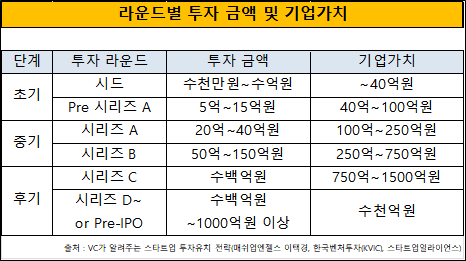

### **-** Funding Stage 값 전처리 수행

(카테고리 별로 묶어주기 위한 과정)

In [71]:
# 간단 전처리
def preprocess(df):
  df.dropna(inplace=True)

  df['Funding_stage']=df['Funding_stage']\
    .str.replace('Unkown','Unknown')\
    .str.replace('Undisclosed','Unknown')#undisclosed는 비공개 데이터로 unknown

  return df

df=preprocess(df)

In [72]:
''' 전처리를 수행해 주었지만 여전히 High cardinarity를 갖고 있음을 알 수 있다.
따라서 큰 범주로 묶어주는 작업이 필요할 것이다.'''

' 전처리를 수행해 주었지만 여전히 High cardinarity를 갖고 있음을 알 수 있다.\n따라서 큰 범주로 묶어주는 작업이 필요할 것이다.'

In [73]:
pd.DataFrame(df['Funding_stage'].value_counts())

,Funding_stage
Series A,949
Seed,840
Series B,650
Series C,463
Series D,249
Series E,135
Unknown,66
Series F,62
Pre-Seed,57
Series G,26


### **-** 0. Funding_stage cat. plan

---

끝난 작업들
- Unknown은 열 추출 후 확인 (Blockchain일 가능성 있을 것 같아서 확인)
  - 확인 결과 아무런 상관관계가 없는 것으로 드러남. 정말 Unknown임...
    - Unknown란을 만들어야겠음
- Private Equity (사모펀드)
  - 어디에 배치해야 할까 고민
  - 따로 항목을 만드는 것이 좋을 것으로 판단
    - 사모펀드 받은 기업들을 Field별로 나눠 확인해 본 결과 액수의 차이가 크고,
    - 나눠 배치하는 것이 어려울 것으로 판단되었다. 
- Angel 열 추출 후 금액 확인하자 --> Seed에 포함된다 할 수 있을지
  - Pre-seed, Seed 영역 (prepare_startup 범주로 분류) #완료
- Preseed, Seed (준비 단계)
  - 보통 엔젤투자자를 통해 SEED 투자가 이루어지는데요.
  - 지인을 비롯해 크라우드펀딩도 SEED 투자자에 속합니다.
    - ICO (initial Coin offering)
    - 크라우드펀딩의 일종이라 한다. --> crowdfunding에 놓자
      - 크라우드 펀딩도 Seed에 속한다 하므로, Seed에 배치
      - 시간 나면 이 분야 Field가 어디인지 알아봐도 좋을 것 같다
- Series A (완료)
- Series B (완료)
- Series C (완료)
- Series D,E,F,G,H (완료)
- Funding, Growth, Grant 열 추출해서 확인 후 넣을 수 있으면 넣기
  -Pre-IPO로 확인 됨
- Debt Financing은 채무를 의미 --> insight를 얻는 방향으로!


---
참고사항
- Unknown란 (기타) 추가 : Extra
  - Debt Financing도 포함해야겠다.
- Private Equity란 추가
- Angel 영역


---
- 시리즈C 투자 단계부터는 제법 덩치가 커집니다.
- VC 중에서도 대형 VC가,투자은행도 참여하기 시작한다.
- 시장 내에 확실한 존재감으로 스케일업에 집중
  - 자체 수익으로도 큰 무리 없이 국내 사업을 영위할 수 있을 정도인데요.
    - 해외시장을 대상으로 다양한 시장 진출을 모색하는 사례가 많습니다.
- 생존을 위한 투자 유치를 지나 인수합병이나 기업공개용으로 투자금을 쓰곤 한다.
[참고자료](https://www.tpiinsight.co.kr/insight/2021/01/27/%EF%BB%BF%EC%8A%A4%ED%83%80%ED%8A%B8%EC%97%85-%ED%88%AC%EC%9E%90-%EB%8B%A8%EA%B3%84-%EC%8B%9C%EB%A6%AC%EC%A6%88-a-b-c-d-e-%EC%B0%A8%EC%9D%B4%EB%8A%94/)



### **-** 1)  Funding_stage 확인 작업



In [74]:
df.head(2)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech
1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech


In [75]:
''' 1. Funding Amount(USD)의 기준 파악  '''
#   USD의 기준이 1달러를 기준으로 하고 있는지 확인하기 위해서 series A 투자 비용을 확인해보겠음

SeriesA= df[df['Funding_stage'].str.contains('Series A')] ## Series A 투자를 받은 행 추출
SeriesA['Funding Amount(USD)'].describe()

count          949.00
mean      18485980.73
std       59014663.01
min         340630.00
25%        7000000.00
50%       11000000.00
75%       18000000.00
max     1500000000.00
Name: Funding Amount(USD), dtype: float64

In [76]:
SeriesA.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
2319,B-North,United Kingdom,Finance,340630,Series A,Jan21,51.51,-0.09,Business
3167,Neurosensum,Indonesia,Artificial Intelligence,600000,Series A,Nov20,-6.21,106.85,Tech
2215,Skyports,United Kingdom,Drones,850000,Series A,Mar20,51.51,-0.09,Tech
1270,Trust Stamp,United States,Cyber Security,1000000,Series A,Mar21,37.09,-95.71,Tech
2764,Vox Digital,Canada,Marketing,1000000,Series A,Jan21,45.42,-75.70,Business
...,...,...,...,...,...,...,...,...,...
3109,HMD,Finland,Electronics,230000000,Series A,Aug20,64.00,26.00,Infra_vehicle
2267,Karma Kitchen,United Kingdom,Food and Beverage,316000000,Series A,Jul20,51.51,-0.09,Health
1026,Calendly,United States,B2B Software,350000000,Series A,Jan21,37.09,-95.71,Tech
1504,Perch,United States,B2B Software,775000000,Series A,May21,37.09,-95.71,Tech


    - 보통 Series A의 투자 규모는 10억에서 30억원까지 올라간다 한다.
    - 평균은 Series A 기준보다 살짝 높은 편에 속하지만, 
      Series A에 속하는 범주들을 Funding Amount 순으로 추려 확인해보면 "달러"를 기준으로 하고 있음을 확인할 수 있다. 

### **-** 2) Funding stage "Unknown"  : 상관관계 확인


In [77]:
df_unknown= df[df['Funding_stage'].str.contains('Unknown')] ## Unknown 영역 추출 (66개 영역)

In [78]:
df_unknown['Field'].value_counts(ascending=False) # Unknown인 영역을 추출해 어떤 Field에 속해있는지 확인

B2B Software               17
Blockchain                  5
Cloud Computing             5
Artificial Intelligence     4
Logistics                   3
Cyber Security              3
FinTech                     3
Health Care                 2
Travel                      2
Finance                     2
Aerospace                   1
Fashion                     1
Consumer                    1
Advertising                 1
Social Network              1
E-Commerce                  1
Education                   1
Electric Vehicles           1
CleanTech                   1
Drones                      1
Autonomous Vehicles         1
Computer Vision             1
Sensor                      1
Electric Vehicle            1
Transportation              1
Air Transportation          1
Quantum Computing           1
Fraud Detection             1
E-Commerce Software         1
Telecommunications          1
Name: Field, dtype: int64

    - Unknown인 영역을 추출해 확인해 본 결과 속해있는 Field(Verticle)가 상이한 것으로 나타남. 
    - 따라서 특정 Field와의 관계는 없는 것으로 드러남. 

### **-** 3) Funding stage: Private Equity

따로 카테고리화 하는 것이 좋을지, 아니면 나눈 범주에 배치하는 것이 좋을지 확인하는 작업이 필요하다.

In [79]:
df_priviateEquity= df[df['Funding_stage'].str.contains('Private Equity')] ## 사모펀드 투자를 받은 행 추출

In [80]:
df_priviateEquity=df_priviateEquity[['Company','Region','Field','Category','Funding Amount(USD)','Funding_stage']]
df_priviateEquity

,Company,Region,Field,Category,Funding Amount(USD),Funding_stage
686,ReliaQuest,United States,Cyber Security,Tech,300000000,Private Equity
751,AppDirect,United States,B2B Software,Tech,185000000,Private Equity
814,Sprinklr,United States,Marketing,Business,200000000,Private Equity
958,Uhuru Design,United States,Product Design,Business,6900000,Private Equity
961,Vimeo,United States,Video,Health,150000000,Private Equity
2013,Sightline Payments,United States,Finance,Business,244000000,Private Equity
2023,Vice Media,United States,Media,Health,85000000,Private Equity
2033,Harri,United States,Recruiting,Business,30000000,Private Equity
2056,Nextiva,United States,Artificial Intelligence,Tech,200000000,Private Equity
2097,Amagi Media Labs,United States,Cloud Computing,Tech,100000000,Private Equity


    - 사모펀드에서의 Tech 영역, 다른 영역들 어떻게 나타나는지
    - Funding Amount를 통해 군집화를 할 수 있을까?
    

In [81]:
privateEquity_grouped = df_priviateEquity.groupby('Category') # 사모펀드 투자 받은 기업들의 Field 카테고리별로 묶어줌

PE_tech_group = privateEquity_grouped.get_group('Tech') # 사모펀드 투자 받은 기업 중 Tech 관련 기업
PE_business_group = privateEquity_grouped.get_group('Business') # 사모펀드 투자 받은 기업 중 Business 관련 기업
PE_health_group = privateEquity_grouped.get_group('Health') # 사모펀드 투자 받은 기업 중 Health 관련 기업
PE_InfraNvehicle_group = privateEquity_grouped.get_group('Infra_vehicle') # 사모펀드 투자 받은 기업 중 Infra 또는 Vehicle에 관련된 기업

In [82]:
# 사모 펀드 투자 받은 기업 중 Tech 관련 기업
PE_tech_group.reset_index().sort_values(by='Funding Amount(USD)',ascending=True)

,index,Company,Region,Field,Category,Funding Amount(USD),Funding_stage
5,2107,3Gtms,United States,Cloud Computing,Tech,15000000,Private Equity
6,2754,Vena,Canada,B2B Software,Tech,25000000,Private Equity
8,3352,LearnUpon,Ireland,Developer Tools,Tech,56000000,Private Equity
3,2097,Amagi Media Labs,United States,Cloud Computing,Tech,100000000,Private Equity
4,2106,Saviynt,United States,Cloud Computing,Tech,130000000,Private Equity
1,751,AppDirect,United States,B2B Software,Tech,185000000,Private Equity
2,2056,Nextiva,United States,Artificial Intelligence,Tech,200000000,Private Equity
0,686,ReliaQuest,United States,Cyber Security,Tech,300000000,Private Equity
7,3084,Berlin Brands Group,Germany,B2B Software,Tech,700000000,Private Equity


    [2107]  1500만원
    [2754]  2500만원
    [3352]  5600만원
    
    [2097]  1억
    [2106]  1.3억
    [751]   1.85억
    [2056]  2억
    [686]   3억
    [3084]  7억


In [83]:
# 사모펀드 투자 받은 기업 중 비즈니스 관련 기업
PE_business_group.reset_index()
PE_business_group = PE_business_group[['Company','Region','Field','Category','Funding_stage','Funding Amount(USD)']]
PE_business_group.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Category,Funding_stage,Funding Amount(USD)
958,Uhuru Design,United States,Product Design,Business,Private Equity,6900000
2033,Harri,United States,Recruiting,Business,Private Equity,30000000
3113,Kodit.io,Finland,Real Estate,Business,Private Equity,117300952
814,Sprinklr,United States,Marketing,Business,Private Equity,200000000
2013,Sightline Payments,United States,Finance,Business,Private Equity,244000000


    [958]   69억
    [2033]  300억
    [3113]  1173억
    [814]   2000억
    [2013]  2440억

In [84]:
# 사모펀드 투자 받은 기업 중 Health 관련 기업
PE_health_group.reset_index()
PE_health_group = PE_health_group[['Company','Region','Field','Category','Funding_stage','Funding Amount(USD)']]
PE_health_group.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Category,Funding_stage,Funding Amount(USD)
2023,Vice Media,United States,Media,Health,Private Equity,85000000
961,Vimeo,United States,Video,Health,Private Equity,150000000
3196,Virtuos,China,Gaming,Health,Private Equity,150000000


    [2023]  850억
    [961]   1500억
    [3196]  1500억

In [85]:
''' 금액이 너무 높아서 다시 확인해봐야 하나 고민하였음'''

' 금액이 너무 높아서 다시 확인해봐야 하나 고민하였음'

In [86]:
# 사모펀드 투자 받은 기업 중 Infra 또는 Vehicle에 관련된 기업
PE_InfraNvehicle_group.reset_index()
PE_InfraNvehicle_group = PE_InfraNvehicle_group[['Company','Region','Field','Category','Funding_stage','Funding Amount(USD)']]
PE_InfraNvehicle_group.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Category,Funding_stage,Funding Amount(USD)
2132,SunShare,United States,Energy,Infra_vehicle,Private Equity,30000000
3370,Avia Solutions Group,Cyprus,Aerospace,Infra_vehicle,Private Equity,351360000
3140,Northvolt,Sweden,Clean Energy,Infra_vehicle,Private Equity,600000000
2573,WestConnex,Australia,Transportation,Infra_vehicle,Private Equity,16600000000


    [2132]  300억
    [3370]  3513억
    [3140]  6000억
    [2573]  16조

결론: 

금액이 너무 높고 상이하기 때문에 어떠한 투자 단계에 배정하는 것에 어려움이 있을 것으로 판단된다.

따라서 사모펀드 범주를 추가하는 것이 좋겠다.

### **-** 4) Funding_stage : Angel

(카테고리화 여부 확인)

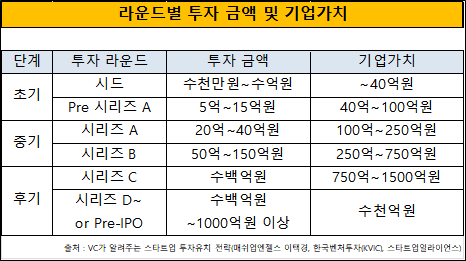

In [87]:
df_angel= df[df['Funding_stage'].str.contains('Angel')] ## 엔젤투자를 받은 행 추출

In [88]:
df_angel = df_angel[['Company','Region','Field','Category','Funding Amount(USD)','Funding_date','Funding_stage']]
df_angel.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Category,Funding Amount(USD),Funding_date,Funding_stage
2534,Bandicoot Imaging Sciences,Australia,E-Commerce Software,Tech,330000,Jul20,Angel
34,tugesto,Spain,B2B Software,Tech,410654,Sep21,Angel
2276,The Insights People,United Kingdom,Market Research,Business,648501,Aug20,Angel
64,Harvestr,France,B2B Software,Tech,650000,Jan20,Angel
2783,RenovationFind,Canada,Recruiting,Business,791067,Mar21,Angel
162,SmartKarrot,United States,B2B Software,Tech,1000000,Jan20,Angel
1949,Refill,United States,B2B Software,Tech,1000000,Aug21,Angel
3101,StreamTV Media,Austria,Media,Health,1171250,Sep21,Angel
2290,Zareklamy,United Kingdom,FinTech,Business,2000000,Sep20,Angel
1459,illumy,United States,Social Network,Tech,2200000,Apr21,Angel


    [2534]  3억
    [34]    4억+a
    [2276]  6.4억
    [64]    6.5억
    [2783]  7.9억
    [162]   10억
    [1949]  10억
    [3101]  11.7억
    [2290]  20억
    [1459]  22억
    [2289]  23.7억
    [2683]  50억
    [2529]  60억
    [248]   100억


- 엔젤투자의 경우 최소 3억부터 100억에 이른다. 
- 특수한 경우를 제외하고 보통 23억 정도에 그치는 것을 확인할 수 있다. 
- (High Cardinarity 방지) 투자 금액에 따라서 카테고리에 배분하는 것이 나을 것으로 판단 되었으나
  - **엔젤투자는 보통 pre-seed, seed 단계에 이뤄진다**고 한다. 따라서 이를 고려해 배분할 것이다.

In [89]:
# [2534,34,2276,64,2783,162,1949,3101] : Prepare_startup (Pre-seed, Seed)
# [2290, 1459, 2289]                   : Series A
# [2683, 2529, 248]                    : Series B

### -5) Funding_stage: Crowdfunding

Crowdfunding은 Seed 영역에 포함된다 한다. 

- Crowdfunding 투자를 받은 기업들을 추려 투자 금액을 확인해보면, 27억~95억 사이에 포진해 있음을 확인할 수 있다. 

In [90]:
crowdfunding_df = df[df['Funding_stage'].str.contains('Crowdfunding')]   #27억~95억 사이에 위치하고 있음
crowdfunding_df

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
2130,EcoFlow,United States,Energy,9595000,Crowdfunding,Sep21,37.09,-95.71,Infra_vehicle
2469,Grow Group,United Kingdom,Cannabis,4821000,Crowdfunding,Aug21,51.51,-0.09,Extra
2510,Trees for Life,United Kingdom,Wellness,2737468,Crowdfunding,Sep21,51.51,-0.09,Health


### -6) Funding_stage : ICO

ICO (Initial Coin Offering)은 Crowdfunding에 포함된다 한다. 

따라서 Seed 영역에 포함시킬 수 있겠다. 

In [91]:
ICO_df = df[(df['Funding_stage'].str.contains('ICO')) | (df['Funding_stage'].str.contains('Initial Coin Offering'))] #37억에서 440억 사이에 위치
ICO_df.sort_values(by='Funding Amount(USD)',ascending=True)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
3237,Persistence One,Singapore,Blockchain,3700000,ICO,Oct20,1.29,103.85,Tech
772,SKALE Labs,United States,Blockchain,5000000,ICO,Sep20,37.09,-95.71,Tech
2242,Celsius Network,United Kingdom,Blockchain,15000000,ICO,Jun20,51.51,-0.09,Tech
729,Republic,United States,Investing,16000000,ICO,Aug20,37.09,-95.71,Business
380,NEAR,United States,Blockchain,22000000,ICO,May20,37.09,-95.71,Tech
2256,Polkadot,United Kingdom,Blockchain,44000000,Initial Coin Offering,Jul20,51.51,-0.09,Tech


### **-** Funding Stage 큰 범주화

- prepare_startup 범주 ( Pre-seed, Seed, 크라우드펀딩, ICO +a)

In [92]:
# Pre-seed와 Seed 단계를 합쳐 prepare_startup을 만들어주었다. 
prepare_startup = df[(df['Funding_stage']=='Pre-Seed')|(df['Funding_stage']=='Seed')]
put_prepare = df.loc[[2534,34,2276,64,2783,162,1949,3101]]
put_crowd = df.loc[[2510,2130,2469]]            #크라우드펀딩
put_ico = df.loc[[3237,772,2242,729,380,2256]]  #ICO


prepare_startup = pd.concat([prepare_startup,put_prepare,put_crowd,put_ico])
prepare_startup

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech
1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech
6,CounterCraft,Spain,Cyber Security,5000000,Seed,Jun20,-3.75,40.46,Tech
7,Kymatio,Spain,Cyber Security,820758,Seed,Jun20,-3.75,40.46,Tech
9,Emjoy,Spain,Wellness,2928926,Seed,Sep20,-3.75,40.46,Health
...,...,...,...,...,...,...,...,...,...
772,SKALE Labs,United States,Blockchain,5000000,ICO,Sep20,37.09,-95.71,Tech
2242,Celsius Network,United Kingdom,Blockchain,15000000,ICO,Jun20,51.51,-0.09,Tech
729,Republic,United States,Investing,16000000,ICO,Aug20,37.09,-95.71,Business
380,NEAR,United States,Blockchain,22000000,ICO,May20,37.09,-95.71,Tech


- Series A 범주

In [93]:
# SeriesA 스타트업과 엔젤투자 중 Series A에 포함되는 영역을 포함하여 SeriesA_startup 범주를 만들어주었다

SeriesA_startup = df[df['Funding_stage'].str.contains('Series A')]
put_seriesA = df.loc[[2290, 1459, 2289]]    #엔젤투자

SeriesA_startup = pd.concat([SeriesA_startup,put_seriesA])
SeriesA_startup

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
2,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46,Tech
3,ANYVERSE,Spain,Autonomous Vehicles,3000000,Series A,Apr20,-3.75,40.46,Infra_vehicle
4,Bloobirds,Spain,B2B Software,3000000,Series A,May20,-3.75,40.46,Tech
5,Zeleros,Spain,Air Transportation,7790000,Series A,Jun20,-3.75,40.46,Infra_vehicle
14,Landbot,Spain,B2B Software,8000000,Series A,Jan21,-3.75,40.46,Tech
...,...,...,...,...,...,...,...,...,...
3552,Tenderly,Serbia,Blockchain,15330000,Series A,Jul21,43.57,21.41,Tech
3553,Tenderly,Serbia,Blockchain,15300000,Series A,Aug21,43.57,21.41,Tech
2290,Zareklamy,United Kingdom,FinTech,2000000,Angel,Sep20,51.51,-0.09,Business
1459,illumy,United States,Social Network,2200000,Angel,Apr21,37.09,-95.71,Tech


- Series B 범주

In [94]:
# SeriesB 스타트업과 엔젤투자 중 Series A에 포함되는 영역을 포함하여 SeriesB_startup 범주를 만들어주었다
SeriesB_startup = df[df['Funding_stage'].str.contains('Series B')]
put_seriesB = df.loc[[2683, 2529, 248]]

SeriesB_startup = pd.concat([SeriesB_startup,put_seriesB])
SeriesB_startup

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
8,Copado,Spain,B2B Software,26000000,Series B,Jun20,-3.75,40.46,Tech
15,Unnax,Spain,Finance,8637890,Series B,Jan21,-3.75,40.46,Business
16,Ironhack,Spain,Education,20000000,Series B,Jan21,-3.75,40.46,Infra_vehicle
18,Copado,Spain,Cloud Computing,96000000,Series B,Feb21,-3.75,40.46,Tech
33,Genially,Spain,B2B Software,20000000,Series B,Sep21,-3.75,40.46,Tech
...,...,...,...,...,...,...,...,...,...
3551,Kushki,Ecuador,Finance,86000000,Series B,Jun21,-1.83,-78.18,Business
3556,Crehana,Peru,Education,70000000,Series B,Aug21,-9.19,-75.02,Infra_vehicle
2683,Zareklamy,Poland,Finance,5000000,Angel,Feb21,51.92,19.15,Business
2529,Limepay,Australia,FinTech,6000000,Angel,May20,-35.31,149.12,Business


- [Pre-IPO] Funding, Growth, Grant 열 추출해서 확인 : Pre-IPO로 결정

In [95]:
pre_IPO = df[(df['Funding_stage'].str.contains('Funding')) | (df['Funding_stage'].str.contains('Growth')) | (df['Funding_stage'].str.contains('Grant'))] #325억 #250억 #575억 #Pre-IPO단계로 넣어줘야겠다.
pre_IPO

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
953,Level,United States,Finance,57560140,Grant,Nov20,37.09,-95.71,Business
1945,MoEngage,United States,B2B Software,32500000,Funding,Aug21,37.09,-95.71,Tech
1998,Product School,United States,Education,25000000,Growth,Aug21,37.09,-95.71,Infra_vehicle


- Debt Financing : After Sereis A

- Debt Financing (채무) --> 부채성 금융 --> C단계 이후로 놔야 함
  - 부채에 투자하는 방식
    - 전환사채(CB),신주인수권부사채(BW), 프로젝트 파이낸싱(PF)가 대표적
  - 보통 CB는 시리즈 C 단계 이후 시작한다고 한다.

(참고자료)

[스타트업 투자 유치 단계](https://better-together.tistory.com/282)

[Debt Financing에 대한 자료](https://www.venturesquare.net/775477)



In [96]:
debt_finance_df = df[df['Funding_stage'].str.contains('Debt Financing')].sort_values(by='Funding Amount(USD)',ascending=True)
debt_finance_df

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category
2706,Adiposs,Switzerland,Education,109663,Debt Financing,Aug20,-26.30,31.30,Infra_vehicle
3414,LUXHUB,Luxembourg,FinTech,8000000,Debt Financing,May20,49.75,6.17,Business
3197,SME Finance,Lithuania,FinTech,10800000,Debt Financing,Mar20,55.17,23.88,Business
705,Axle,United States,FinTech,25000000,Debt Financing,Aug20,37.09,-95.71,Business
678,Feather,United States,Consumer,30000000,Debt Financing,Aug20,37.09,-95.71,Business
557,Puppet,United States,B2B Software,40000000,Debt Financing,Jul20,37.09,-95.71,Tech
358,MemSQL,United States,B2B Software,50000000,Debt Financing,May20,37.09,-95.71,Tech
947,Udacity,United States,Education,75000000,Debt Financing,Nov20,37.09,-95.71,Infra_vehicle
424,Homeward,United States,Real Estate,85000000,Debt Financing,May20,37.09,-95.71,Business
397,Nautilus Data,United States,Data Center,100000000,Debt Financing,May20,37.09,-95.71,Tech


In [97]:
debt_finance_df.Field.value_counts()

FinTech                4
Education              2
B2B Software           2
Cloud Data Services    1
Real Estate            1
Consumer               1
Data Center            1
Name: Field, dtype: int64

In [98]:
# debt_financed_df의 인덱스 : [2706,3414,3197,705,678,557,358,947,424,397,711,215]

Text(0, 0.5, 'Count')

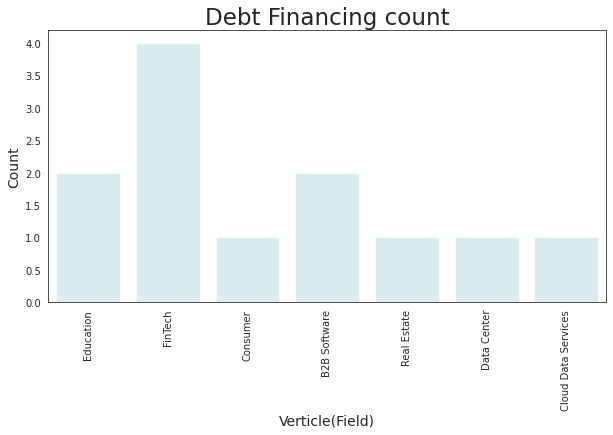

In [99]:
fig3= plt.figure(figsize=(10,5))
fig3.add_subplot(1,1,1)
ax3=sns.countplot(debt_finance_df['Field'],color='#b0e0e6',alpha=0.5)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation = 90)
ax3.set_title('Debt Financing count',fontsize=23)
ax3.set_xlabel('Verticle(Field)',fontsize=14)
ax3.set_ylabel('Count',fontsize=14)

In [100]:
# Debt Financing 비율 확인
debt_finance_df['Category'].value_counts(normalize=True)

Business        0.50
Tech            0.33
Infra_vehicle   0.17
Name: Category, dtype: float64

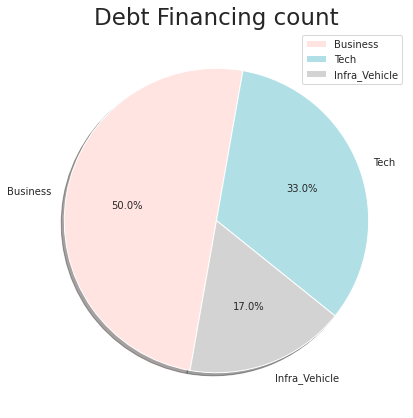

In [101]:
ratio = [50, 33, 17]
labels = ['Business', 'Tech', 'Infra_Vehicle']
colors = ['#ffe4e1','#b0e0e6','lightgray']
#plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, shadow=True, colors=colors)

fig4= plt.figure(figsize=(7,7))
fig4.add_subplot(1,1,1)
ax4=plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, shadow=True, colors=colors)
plt.title('Debt Financing count',fontsize=23)
# 레전드 달기
plt.legend(['Business','Tech','Infra_Vehicle'], loc='upper right')

엔젤투자가 아닌 다른 범주들도 Funding stage에 따라 범주화하여 카테고리를 만들어보겠다. 

In [102]:
# SeriesC 범주
SeriesC_startup = df[df['Funding_stage'].str.contains('Series C')]


# SeriesC 이후 재투자를 받은 투자 기업들 또는 Pre-IPO:
''' 보통 SeriesC까지 투자를 받지만, IPO에 가기 전 다른 boosting이 필요하거나,  Public으로 가기전 도움이 더 필요한 기업들'''

SeriesAfter_startup = df[(df['Funding_stage'].str.contains('Series D')) | (df['Funding_stage'].str.contains('Series E')) | (df['Funding_stage'].str.contains('Series F')) | 
                         (df['Funding_stage'].str.contains('Series G')) | (df['Funding_stage'].str.contains('Series H'))]
SeriesAfter_startup = pd.concat([SeriesAfter_startup,pre_IPO]) # Pre-IPO까지 합쳐줬다.
SeriesAfter_startup = pd.concat([SeriesAfter_startup,debt_finance_df])# Debt_finance까지 합쳐줬다.

# Private Equity 범주 (사모펀드)
PriviateEquity_startup = df[df['Funding_stage'].str.contains('Private Equity')]

In [103]:
prepare_startup['invest_pace']='prepare_startup'
prepare_startup.head(1)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech,prepare_startup


In [104]:
prepare_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

In [105]:
SeriesA_startup['invest_pace']='Series A'
SeriesA_startup.head(1)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
2,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46,Tech,Series A


In [106]:
SeriesA_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

In [107]:
SeriesB_startup['invest_pace']='Series B'
SeriesB_startup.head(1)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
8,Copado,Spain,B2B Software,26000000,Series B,Jun20,-3.75,40.46,Tech,Series B


In [108]:
SeriesB_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

In [109]:
SeriesC_startup['invest_pace']='Series C'
SeriesC_startup.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
17,Jobandtalent,Spain,Recruiting,107652239,Series C,Jan21,-3.75,40.46,Business,Series C


In [110]:
SeriesC_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

In [111]:
SeriesAfter_startup['invest_pace']='Pre-IPO'
SeriesAfter_startup.head(1)

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
20,Wallapop,Spain,Marketplace,191161053,Series G,Feb21,-3.75,40.46,Business,Pre-IPO


In [112]:
SeriesAfter_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

In [113]:
PriviateEquity_startup['invest_pace']='PE'
PriviateEquity_startup.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
686,ReliaQuest,United States,Cyber Security,300000000,Private Equity,Aug20,37.09,-95.71,Tech,PE


In [114]:
PriviateEquity_startup.isna().sum()

Company                0
Region                 0
Field                  0
Funding Amount(USD)    0
Funding_stage          0
Funding_date           0
latitude               0
longtitude             0
Category               0
invest_pace            0
dtype: int64

### **-** invest_pace를 추가하여 만들어준 데이터프레임들을 합치도록 하자(Extra, Unknown 제외)

In [115]:
merged_df= pd.concat([prepare_startup,SeriesA_startup,SeriesB_startup,SeriesC_startup,SeriesAfter_startup,PriviateEquity_startup])
merged_df

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech,prepare_startup
1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech,prepare_startup
6,CounterCraft,Spain,Cyber Security,5000000,Seed,Jun20,-3.75,40.46,Tech,prepare_startup
7,Kymatio,Spain,Cyber Security,820758,Seed,Jun20,-3.75,40.46,Tech,prepare_startup
9,Emjoy,Spain,Wellness,2928926,Seed,Sep20,-3.75,40.46,Health,prepare_startup
...,...,...,...,...,...,...,...,...,...,...
3113,Kodit.io,Finland,Real Estate,117300952,Private Equity,Oct20,64.00,26.00,Business,PE
3140,Northvolt,Sweden,Clean Energy,600000000,Private Equity,Sep20,59.62,16.55,Infra_vehicle,PE
3196,Virtuos,China,Gaming,150000000,Private Equity,Sep21,35.86,104.20,Health,PE
3352,LearnUpon,Ireland,Developer Tools,56000000,Private Equity,Oct20,53.33,-6.25,Tech,PE


- df에 병합

In [116]:
total_df = pd.merge(df,merged_df, how='outer')
total_df

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech,prepare_startup
1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech,prepare_startup
2,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46,Tech,Series A
3,ANYVERSE,Spain,Autonomous Vehicles,3000000,Series A,Apr20,-3.75,40.46,Infra_vehicle,Series A
4,Bloobirds,Spain,B2B Software,3000000,Series A,May20,-3.75,40.46,Tech,Series A
...,...,...,...,...,...,...,...,...,...,...
3555,MarketForce,Kenya,B2B Software,100000,Seed,Aug21,1.00,38.00,Tech,prepare_startup
3556,Crehana,Peru,Education,70000000,Series B,Aug21,-9.19,-75.02,Infra_vehicle,Series B
3557,Tiki Corporation,Vietnam,Marketplace,20000000,Series E,Aug21,21.02,105.84,Business,Pre-IPO
3558,Bloktopia,Isle of Man,Blockchain,4200000,Seed,Sep21,54.15,4.30,Tech,prepare_startup


In [117]:
total_df.isna().sum() # Extra 부분만 결측치로 처리되어 있다.

Company                 0
Region                  0
Field                   0
Funding Amount(USD)     0
Funding_stage           0
Funding_date            0
latitude                0
longtitude              0
Category                0
invest_pace            66
dtype: int64

In [118]:
total_df.loc[total_df['invest_pace'].isna()==True , 'invest_pace'] = 'Extra'

In [119]:
total_df.loc[total_df['invest_pace']=='Extra']

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
53,Cumul.io,Belgium,B2B Software,4171891,Unknown,Nov20,50.50,4.47,Tech,Extra
90,Synapse Medicine,France,Health Care,8000000,Unknown,Jul20,48.80,2.35,Health,Extra
314,XRHealth,United States,Health Care,7000000,Unknown,Apr20,37.09,-95.71,Health,Extra
344,Waymo,United States,Autonomous Vehicles,750000000,Unknown,May20,37.09,-95.71,Infra_vehicle,Extra
346,Procore,United States,B2B Software,150000000,Unknown,May20,37.09,-95.71,Tech,Extra
...,...,...,...,...,...,...,...,...,...,...
3348,Scurri,Ireland,Logistics,1683743,Unknown,Jun20,53.33,-6.25,Extra,Extra
3371,Slimmer,The Netherlands,Artificial Intelligence,4000000,Unknown,May20,52.13,5.29,Tech,Extra
3373,VanMoof,The Netherlands,Electric Vehicle,14000000,Unknown,May20,52.13,5.29,Infra_vehicle,Extra
3374,Open Social,The Netherlands,B2B Software,1000000,Unknown,Jul20,52.13,5.29,Tech,Extra


In [120]:
total_df # data wrangling 후 도출된 데이터프레임

,Company,Region,Field,Funding Amount(USD),Funding_stage,Funding_date,latitude,longtitude,Category,invest_pace
0,Internxt,Spain,Blockchain,278940,Seed,Jan20,-3.75,40.46,Tech,prepare_startup
1,Internxt,Spain,Blockchain,268000,Seed,Mar20,-3.75,40.46,Tech,prepare_startup
2,Factorial,Spain,B2B Software,16000000,Series A,Apr20,-3.75,40.46,Tech,Series A
3,ANYVERSE,Spain,Autonomous Vehicles,3000000,Series A,Apr20,-3.75,40.46,Infra_vehicle,Series A
4,Bloobirds,Spain,B2B Software,3000000,Series A,May20,-3.75,40.46,Tech,Series A
...,...,...,...,...,...,...,...,...,...,...
3555,MarketForce,Kenya,B2B Software,100000,Seed,Aug21,1.00,38.00,Tech,prepare_startup
3556,Crehana,Peru,Education,70000000,Series B,Aug21,-9.19,-75.02,Infra_vehicle,Series B
3557,Tiki Corporation,Vietnam,Marketplace,20000000,Series E,Aug21,21.02,105.84,Business,Pre-IPO
3558,Bloktopia,Isle of Man,Blockchain,4200000,Seed,Sep21,54.15,4.30,Tech,prepare_startup


In [121]:
total_df.invest_pace.unique()

array(['prepare_startup', 'Series A', 'Series B', 'Series C', 'Pre-IPO',
       'Extra', 'PE'], dtype=object)

In [122]:
df3 = total_df.copy()
df3 = df3[['Company','Region','Field','Category','invest_pace','Funding_date','Funding Amount(USD)']]
df3

,Company,Region,Field,Category,invest_pace,Funding_date,Funding Amount(USD)
0,Internxt,Spain,Blockchain,Tech,prepare_startup,Jan20,278940
1,Internxt,Spain,Blockchain,Tech,prepare_startup,Mar20,268000
2,Factorial,Spain,B2B Software,Tech,Series A,Apr20,16000000
3,ANYVERSE,Spain,Autonomous Vehicles,Infra_vehicle,Series A,Apr20,3000000
4,Bloobirds,Spain,B2B Software,Tech,Series A,May20,3000000
...,...,...,...,...,...,...,...
3555,MarketForce,Kenya,B2B Software,Tech,prepare_startup,Aug21,100000
3556,Crehana,Peru,Education,Infra_vehicle,Series B,Aug21,70000000
3557,Tiki Corporation,Vietnam,Marketplace,Business,Pre-IPO,Aug21,20000000
3558,Bloktopia,Isle of Man,Blockchain,Tech,prepare_startup,Sep21,4200000


### 5) Company : insight

In [123]:
df3['Company'].value_counts()

Human Interest    4
M1 Finance        4
Thrasio           4
SpotOn            4
Robinhood         4
                 ..
Tankfarm          1
HyperQube         1
Clustermarket     1
Incorta           1
Command E         1
Name: Company, Length: 3209, dtype: int64

In [124]:
df3[df3['Company'].str.contains('Thrasio')] ## df[조건식]---1)

,Company,Region,Field,Category,invest_pace,Funding_date,Funding Amount(USD)
285,Thrasio,United States,Investing,Business,Series B,Apr20,75000000
613,Thrasio,United States,Investing,Business,Series C,Jul20,260000000
1116,Thrasio,United States,B2B Software,Tech,Pre-IPO,Feb21,750000000
1368,Thrasio,United States,B2B Software,Tech,Series C,Apr21,100000000


- 4개 투자 받은 기업이 같은 Field만을 갖고 있는 것은 아니다.
- 같은 카테고리 항목이 같은 사업 아이템을 뜻하는 것이라 판단하기에는 정보가 부족하여 판단이 어렵다. 

In [125]:
funded_company= df3.Company.value_counts().reset_index()
funded_company

,index,Company
0,Human Interest,4
1,M1 Finance,4
2,Thrasio,4
3,SpotOn,4
4,Robinhood,4
...,...,...
3204,Tankfarm,1
3205,HyperQube,1
3206,Clustermarket,1
3207,Incorta,1


In [126]:
print("4개 투자 받은 Company:", funded_company.query('Company==4').index.nunique())
print("3개 투자 받은 Company:", funded_company.query('Company==3').index.nunique())
print("2개 투자 받은 Company:", funded_company.query('Company==2').index.nunique())
print("1개 투자 받은 Company:", funded_company.query('Company==1').index.nunique())

4개 투자 받은 Company: 6
3개 투자 받은 Company: 30
2개 투자 받은 Company: 273
1개 투자 받은 Company: 2900


(-3.0, 3050.0)

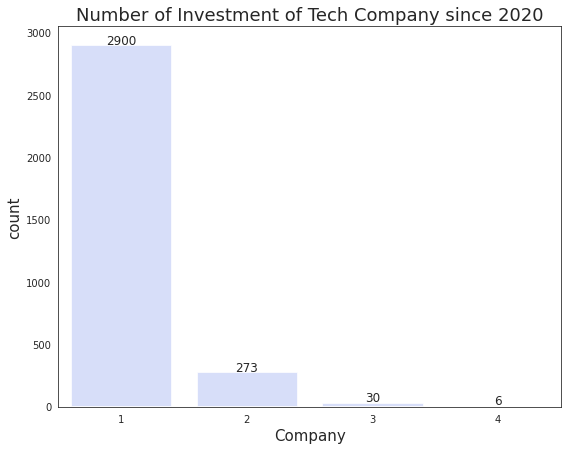

In [127]:
sns.set_style('white')
fig5= plt.figure(figsize=(9,7))
area5 = fig5.add_subplot(1,1,1)
area5.set_title('Number of Investment of Tech Company since 2020',fontsize=18)
area5.set_xlabel('Number invested',fontsize=15)
area5.set_ylabel('count company',fontsize=15)
ax5=sns.countplot(x=funded_company['Company'],data=funded_company, color='#BECDFF',alpha=0.7,ax=area5)

for p in ax5.patches:
    height = p.get_height()
    ax5.text(p.get_x() + p.get_width() / 2., height + 10, height, ha = 'center', size = 12)
ax5.set_ylim(-3,3050)

In [128]:
funded_company_4 = funded_company.query('Company==4')
funded_company_4

,index,Company
0,Human Interest,4
1,M1 Finance,4
2,Thrasio,4
3,SpotOn,4
4,Robinhood,4
5,Internxt,4


In [129]:
df3[df3['Company'].str.contains('Internxt')] ## df[조건식]---2) 

,Company,Region,Field,Category,invest_pace,Funding_date,Funding Amount(USD)
0,Internxt,Spain,Blockchain,Tech,prepare_startup,Jan20,278940
1,Internxt,Spain,Blockchain,Tech,prepare_startup,Mar20,268000
10,Internxt,Spain,Blockchain,Tech,prepare_startup,Oct20,210926
12,Internxt,Spain,Cyber Security,Tech,prepare_startup,Jan21,303419


- 4개 항목을 투자 받았다 해서 그것이 invest_pace가 높다는 것은 아니다.

In [130]:
# 재확인
df3[df3['Company'].str.contains('SpotOn')] ## df[조건식]---3) 

,Company,Region,Field,Category,invest_pace,Funding_date,Funding Amount(USD)
218,SpotOn,United States,FinTech,Business,Series B,Mar20,50000000
767,SpotOn,United States,B2B Software,Tech,Series C,Sep20,60000000
1489,SpotOn,United States,B2B Software,Tech,Pre-IPO,May21,125000000
2067,SpotOn,United States,B2B Software,Tech,Pre-IPO,Sep21,300000000


3번 이상 투자 받은 기업들

In [131]:
funded_company_43 = funded_company.query('Company==4 | Company==3')
funded_company_43.shape

(36, 2)

[Text(0, 0.5, 'count'), Text(0.5, 0, 'company')]

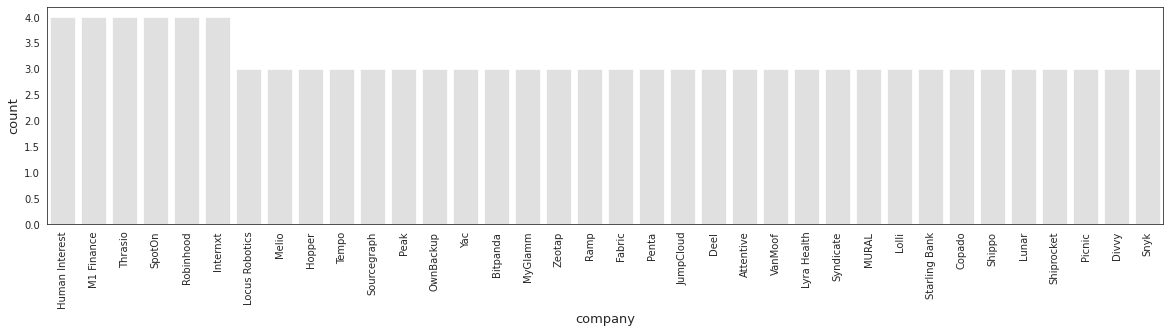

In [132]:
fig6= plt.figure(figsize=(20,4))
area6 = fig6.add_subplot(1,1,1)
plt.xticks(rotation=90)
area6.set_xlabel('Company invested',fontsize=13)
area6.set_ylabel('number invested',fontsize=13)
funded_company_bar = sns.barplot(x = funded_company_43['index'], y =funded_company_43['Company'],color='lightgray',alpha=0.7)
funded_company_bar.set(xlabel="company", ylabel="count")

## **5**. Targeting

In [133]:
# 시리즈 C 이상 --> domestic에서는 scaled, 자체 수익으로 기업 영위 가능 : Domestic Scaled 로 분류 
target_criteria=df3[df3['invest_pace'].str.contains('Series C')]['Funding Amount(USD)'].min()
print("target criteria: ",target_criteria)

target criteria:  3011648


- 타겟팅의 기준을 Series C의 최소값으로 잡아주었다.

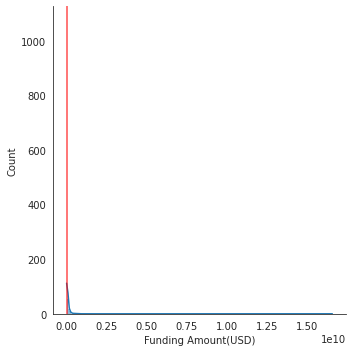

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df3['Funding Amount(USD)'],kde=True);
plt.axvline(target_criteria,color='red',alpha=0.7);

In [135]:
df3['Domestic_Scaled']=df3['Funding Amount(USD)']>=target_criteria
df3['Domestic_Scaled'].nunique()

2

Target 범주 확인 및 비율 확인

In [136]:
df3['Domestic_Scaled'].value_counts()

True     2932
False     628
Name: Domestic_Scaled, dtype: int64

In [137]:
df3['Domestic_Scaled'].value_counts(normalize=True)

True    0.82
False   0.18
Name: Domestic_Scaled, dtype: float64

다수 클래스(majority class) 비율이 50%~70% 인 경우 정확도(accuracy)만 사용해도 무방하다. 

그러나 **타겟으로 잡은 Domestic_Scaled의 비중이 82%로 다수 클래스 비율이 매우 높다. 이 때 정확도 이외의 지표들에 대한 점검이 필요**하다.

- 분류모델이기 때문에 log transform을 진행하진 않았다.

- 다중공산성의 위험이 있기 때문에 **Funding Amount(USD) 항목을 제거**해준다.
- Funding_date는 사용하지 않을 것으로 보이므로 제거해주겠다. 

In [138]:
df3.head(2)

,Company,Region,Field,Category,invest_pace,Funding_date,Funding Amount(USD),Domestic_Scaled
0,Internxt,Spain,Blockchain,Tech,prepare_startup,Jan20,278940,False
1,Internxt,Spain,Blockchain,Tech,prepare_startup,Mar20,268000,False


In [139]:
df3 = df3[['Company','Region','Field','Category','invest_pace','Domestic_Scaled']]

## **6**. Data Leakage 확인 : OrdinalEncoder, DecisionTree 사용

In [140]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 463 kB/s 


Data Leakage 확인 위해 Train, Val set으로 나눠줌

In [141]:
from sklearn.model_selection import train_test_split
train_pre, val_pre = train_test_split(df3,test_size=0.2,random_state=2)
train_pre.shape,val_pre.shape

((2848, 6), (712, 6))

In [142]:
target = 'Domestic_Scaled'
features = df3.columns.drop([target])

X_train_pre = train_pre[features]
X_val_pre = val_pre[features]
y_train_pre = train_pre[target]
y_val_pre = val_pre[target]

In [143]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train_pre,y_train_pre)
print('검증 정확도: ',pipe.score(X_val_pre,y_val_pre))

검증 정확도:  0.8342696629213483


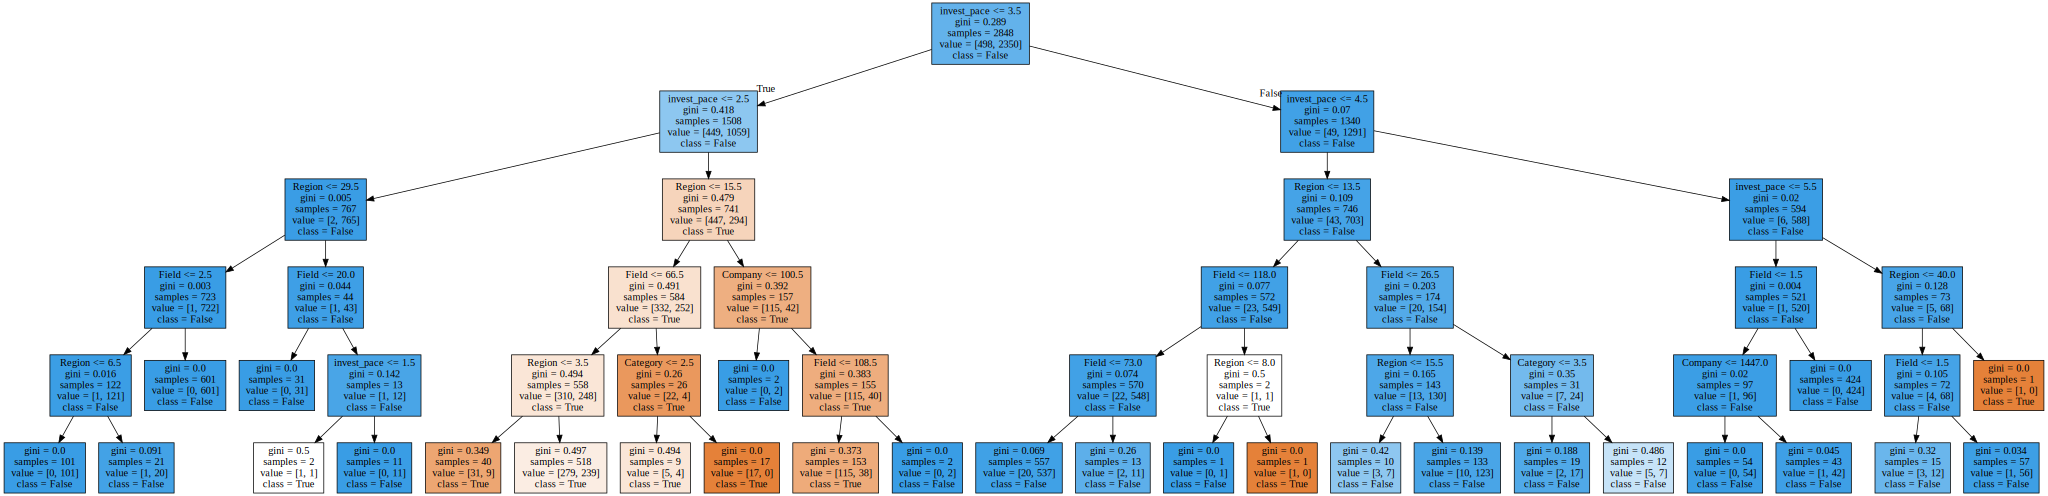

In [144]:
import graphviz
from sklearn.tree import export_graphviz

tree= pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train_pre.columns,
    class_names=y_train_pre.unique().astype(str),
    filled=True
)
graphviz.Source(dot_data)

다수 클래스의 비율이 높았으므로 정확도 이외의 평가지표들에 대한 확인을 추가적으로 진행한다. 

Text(0.5, 1.0, 'Confusion matrix, n=712')

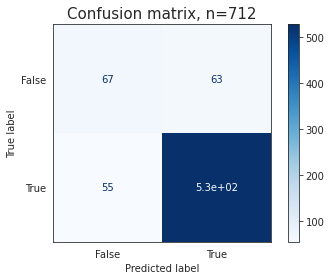

In [145]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
pcm = plot_confusion_matrix(pipe,X_val_pre,y_val_pre,
                            cmap=plt.cm.Blues,
                            ax=ax);

plt.title(f'Confusion matrix, n={len(y_val_pre)}',fontsize =15)

In [146]:
from sklearn.metrics import classification_report
y_pred_pre = pipe.predict(X_val_pre)
print(classification_report(y_val_pre,y_pred_pre))

              precision    recall  f1-score   support

       False       0.55      0.52      0.53       130
        True       0.89      0.91      0.90       582

    accuracy                           0.83       712
   macro avg       0.72      0.71      0.72       712
weighted avg       0.83      0.83      0.83       712



해석해보기
- confusion matrix를 살펴보면, TP는 굉장히 높지만 다른 부분들에서는 값들이 높지 않은 것으로 드러난다. 
  - Target의 분포가 True에 82%로 치우쳐져 있었던 것이 드러난 결과
  - 이에 대한 결과는 classification report에서도 확인할 수 있다. 
- 정확도는 상대적으로 높게 나타난다. 83%를 차지하고 있다. 그런데 타겟의 다수 클래스의 비율이 굉장히 높게 나오기 때문에 다른 지표들을 확인해봐야 한다. 


- Precision(정밀도): 검출 결과물 중 실제가 포함되어 있을 확률을 나타내는 정밀도를 살펴보면, True 범주에선 높게 나타나지만, False 범주에선 낮은 것으로 확인된다. 
- Recall (재현율) : 대상 물체들을 얼마나 빠짐 없이 잡아내느냐를 나타내는 재현율은 True 범주에서는 91%로 굉장히 높게 나타나지만, False 범주에서는 52%로 굉장히 낮게 나타나고 있다. 

- 물론 균형을 맞춰야겠지만, 모델의 타겟을 Domestic에서 Scaled 된 기업을 대상으로 하고 있기 때문에, 정밀도보다는 재현율이 중요하다.

> 예측하고자 하는 모델은 Domestic에서 Scaled된 지표를 찾는 것

> 실제값이 Positive일 때 예측한 값이 Positive한 경우에 더 적합하다. 따라서 Recall 지표가 사용되어야 한다.

- 이를 위해 Threshold(분류 결정 임계값)를 낮춰 재현율을 높여야한다. 
  - ROC curve, AUC를 사용하면 분류문제에서 여러 임계값 설정에 대한 모델의 성능을 구할 수 있다. 
  - ROC curve는 여러 임계값에 대해 TPR(True Positive Rate, recall)과 FPR(False Positive Rate) 그래프를 보여준다. 
  - 재현율은 최대화 하고 위양성률은 최소화 하는 임계값이 최적의 임계값




개념 점검:

- Precision(정밀도) : 모델이 True라고 예측했을 때, 실제값이 True인 비율
  - Precision = TP / TP+FP
  - 정밀도는 모델이 Positive라고 예측했을 때 실제값이 Negative일 때 위험이 수반되는 경우


- Recall(재현율) : 실제값이 True일 때, 그 값들을 모델이 True라고 예측한 비율 = (민감도, 특이도)
  - Recall = TP / TP+FN
  - . 재현율은 **보통 실제값이 Positive일 때 예측한 값이 Positive일 경우**가 매우 중요한 상황일 때 사용
- 정밀도와 재현율은 Trade-off 관계

In [147]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr_pre, tpr_pre, thresholds_pre = roc_curve(y_val_pre, y_pred_pre)

roc_pre = pd.DataFrame({
    'FPR(Fall-out)': fpr_pre, 
    'TPRate(Recall)': tpr_pre, 
    'Threshold': thresholds_pre
})
roc_pre

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.00,0.00,2
1,0.48,0.91,1
2,1.00,1.00,0


ROC curve: TPR, FPR을 x축과 y축에 놓은 그래프

- TPR (True Positive Rate) : 1인 케이스에 대해 1로 맞게 예측한 경우 = 민감도, 재현율
- FPR (False Positive Rate): 0인 케이스에 대해 1로 잘못 예측한 경우 = 1-특이도

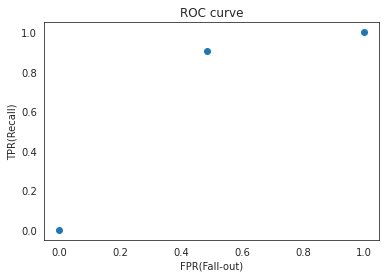

In [148]:
plt.scatter(fpr_pre, tpr_pre)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [149]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx_pre = np.argmax(tpr_pre - fpr_pre)
optimal_threshold_pre = thresholds_pre[optimal_idx_pre]

print('idx:', optimal_idx_pre, ', threshold:', optimal_threshold_pre)

idx: 1 , threshold: 1


임계값에 따른 비교

In [150]:
y_pred_pre_05 = y_pred_pre >= 0. # 임계값이 0.5일 때
print(classification_report(y_val_pre, y_pred_pre_05))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       130
        True       0.82      1.00      0.90       582

    accuracy                           0.82       712
   macro avg       0.41      0.50      0.45       712
weighted avg       0.67      0.82      0.74       712



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
y_pred_optimal = y_pred_pre >= optimal_threshold_pre # 최적의 임계값일 때 
print(classification_report(y_val_pre, y_pred_optimal))

              precision    recall  f1-score   support

       False       0.55      0.52      0.53       130
        True       0.89      0.91      0.90       582

    accuracy                           0.83       712
   macro avg       0.72      0.71      0.72       712
weighted avg       0.83      0.83      0.83       712



- 임계값이 0.5일 때 False 범주의 예측은 전혀 하지 못하는 것을 발견할 수 있다.
- 이와 달리 최적의 임계값인 1에서의 경우, True 범주와의 차이는 있지만 예측이 가능한 것으로 드러난다. 

AUC 구하기

In [152]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val_pre, y_pred_pre)
auc_score

0.7104414485857784

## **7**. 모델 구축

### OneHotEncoding

In [153]:
df3.columns

Index(['Company', 'Region', 'Field', 'Category', 'invest_pace',
       'Domestic_Scaled'],
      dtype='object')

In [154]:
df3.head(2)

,Company,Region,Field,Category,invest_pace,Domestic_Scaled
0,Internxt,Spain,Blockchain,Tech,prepare_startup,False
1,Internxt,Spain,Blockchain,Tech,prepare_startup,False


In [155]:
df3.Field.nunique() # High Cardinarity, Category란과 겹칠 수 있기 때문에 다중공산성의 위험이 있으므로 제외하도록 하겠다.

143

In [156]:
# columns = ['Company', 'Region', 'Field', 'Category', 'invest_pace','Domestic_Scaled']

In [157]:
X = pd.get_dummies(df3.drop(['Region','Company','Field'],axis=1),
                   columns = ['Category', 'invest_pace'],drop_first=True)
#y = df3['Domestic_Scaled']

In [158]:
X

,Domestic_Scaled,Category_Extra,Category_Health,Category_Infra_vehicle,Category_Tech,invest_pace_PE,invest_pace_Pre-IPO,invest_pace_Series A,invest_pace_Series B,invest_pace_Series C,invest_pace_prepare_startup
0,False,0,0,0,1,0,0,0,0,0,1
1,False,0,0,0,1,0,0,0,0,0,1
2,True,0,0,0,1,0,0,1,0,0,0
3,False,0,0,1,0,0,0,1,0,0,0
4,False,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3555,False,0,0,0,1,0,0,0,0,0,1
3556,True,0,0,1,0,0,0,0,1,0,0
3557,True,0,0,0,0,0,1,0,0,0,0
3558,True,0,0,0,1,0,0,0,0,0,1


### 모델 구축을 위한 데이터셋 분리(Train, Val, Test set)

In [159]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X, test_size=0.2, random_state=2)

In [160]:
print("pre-train shape :",train.shape)
print("test shape    :",test.shape)

pre-train shape : (2848, 11)
test shape    : (712, 11)


In [161]:
train, val = train_test_split(train, test_size=0.2, random_state=2)
print("Train shape",train.shape)
print("Val shape",val.shape)
print("Test shape",test.shape)

Train shape (2278, 11)
Val shape (570, 11)
Test shape (712, 11)


In [162]:
target = 'Domestic_Scaled'

X_train = train.drop(target,axis=1)
y_train = train[target]

X_val = val.drop(target,axis=1)
y_val = val[target]

X_test = test.drop(target,axis=1)
y_test = test[target]

In [163]:
print("훈련용 데이터:\n","X_train: ",X_train.shape,"\n y_train: ",y_train.shape)
print("\n검증용 데이터\n:","X_val   : ",X_val.shape,"\n  y_val   : ",y_val.shape)
print("\n테스트용 데이터:\n","X_test:   ",X_test.shape)

훈련용 데이터:
 X_train:  (2278, 10) 
 y_train:  (2278,)

검증용 데이터
: X_val   :  (570, 10) 
  y_val   :  (570,)

테스트용 데이터:
 X_test:    (712, 10)


## **8**. 모델 학습

### LogisticRegression model 학습: Validation set

In [164]:
from sklearn.linear_model import LogisticRegression 

pipe_lr = make_pipeline(
          LogisticRegression(max_iter=10000)
)

pipe_lr.fit(X_train,y_train)
print('검증 정확도: ',pipe_lr.score(X_val,y_val))

검증 정확도:  0.8842105263157894


모델 검증

- confusion matrix

Text(0.5, 1.0, 'Confusion matrix, n=570')

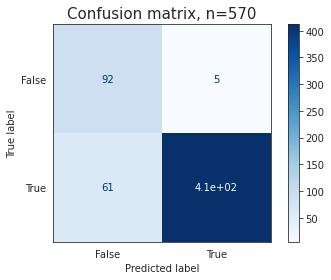

In [165]:
# confusion matrix 확인 
fig,ax2=plt.subplots()
pcm = plot_confusion_matrix(pipe_lr,X_val,y_val,
                            cmap=plt.cm.Blues,
                            ax=ax2);

plt.title(f'Confusion matrix, n={len(y_val)}',fontsize =15)

- classification report

In [166]:
pred_lr = pipe_lr.predict(X_val)
print(classification_report(y_val,pred_lr))

              precision    recall  f1-score   support

       False       0.60      0.95      0.74        97
        True       0.99      0.87      0.93       473

    accuracy                           0.88       570
   macro avg       0.79      0.91      0.83       570
weighted avg       0.92      0.88      0.89       570



- roc, auc score 확인

In [167]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe_lr.predict_proba(X_val)[:,-1]
print('AUC score :',roc_auc_score(y_val,y_pred_proba))

AUC score : 0.9135045007737407


Text(0, 0.5, 'TPR')

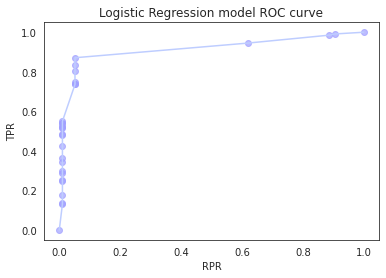

In [168]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba)

plt.scatter(fpr,tpr,color='#A0A0FF',alpha=0.7)
plt.plot(fpr,tpr,color='#BECDFF')
plt.title('Logistic Regression model ROC curve')
plt.xlabel('RPR')
plt.ylabel('TPR')

### XG boost model 학습: Validation set

In [169]:
from xgboost import XGBClassifier

pipe_xgb = make_pipeline(
            XGBClassifier()
)

pipe_xgb.fit(X_train,y_train)
print('검증 정확도: ',pipe_xgb.score(X_val,y_val))

검증 정확도:  0.8842105263157894


- confusion matrix 확인

Text(0.5, 1.0, 'Confusion matrix, n=570')

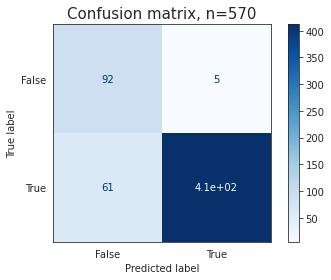

In [170]:
# confusion matrix 확인 
fig,ax3=plt.subplots()
pcm = plot_confusion_matrix(pipe_xgb,X_val,y_val,
                            cmap=plt.cm.Blues,
                            ax=ax3);

plt.title(f'Confusion matrix, n={len(y_val)}',fontsize =15)

- classification report 확인

In [171]:
pred_xgb = pipe_xgb.predict(X_val)
print(classification_report(y_val,pred_xgb))

              precision    recall  f1-score   support

       False       0.60      0.95      0.74        97
        True       0.99      0.87      0.93       473

    accuracy                           0.88       570
   macro avg       0.79      0.91      0.83       570
weighted avg       0.92      0.88      0.89       570



- roc, auc score 확인

In [172]:
from sklearn.metrics import roc_auc_score

y_pred_proba_xgb = pipe_xgb.predict_proba(X_val)[:,-1]
print('AUC score :',roc_auc_score(y_val,y_pred_proba_xgb))

AUC score : 0.9142891392951329


Text(0, 0.5, 'TPR')

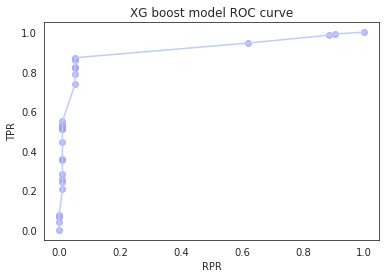

In [173]:
from sklearn.metrics import roc_curve

fpr2, tpr2, thresholds = roc_curve(y_val,y_pred_proba_xgb)

plt.scatter(fpr2,tpr2,color='#A0A0FF',alpha=0.7)
plt.plot(fpr2,tpr2,color='#BECDFF')
plt.title('XG boost model ROC curve')
plt.xlabel('RPR')
plt.ylabel('TPR')

In [174]:
pipe_xgb.named_steps

{'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)}

    - logistic Regression model과 XGboost model의 정확도와 classification report 수치가 같게 나왔다. 
    - 하이퍼파라미터를 조절해서 모델들이 어떻게 변하는지 확인해 보았으나, 변화가 없었다.

In [175]:
pipe_xgb_hy5 = make_pipeline(
                            XGBClassifier(
                                learning_rate =0.1,
                                n_estimators=1000,
                                max_depth=5,
                                min_child_weight=1,
                                gamma=0,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                objective= 'binary:logistic',
                                nthread=-1,
                                scale_pos_weight=1,
                                seed=1000))

pipe_xgb_hy5.fit(X_train,y_train)
print('검증 정확도: ',pipe_xgb_hy5.score(X_val,y_val))

검증 정확도:  0.8842105263157894


## **9**. 최종 모델 학습

In [176]:
pipe_xgb.fit(X_val,y_val)
print('검증 정확도: ',pipe_xgb.score(X_test,y_test))

검증 정확도:  0.8665730337078652


Text(0.5, 1.0, 'Confusion matrix, n=712')

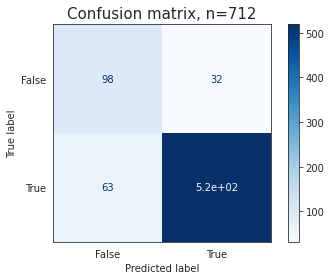

In [177]:
# confusion matrix 확인 
fig,ax4=plt.subplots()
pcm = plot_confusion_matrix(pipe_xgb,X_test,y_test,
                            cmap=plt.cm.Blues,
                            ax=ax4);

plt.title(f'Confusion matrix, n={len(y_test)}',fontsize =15)

In [178]:
from sklearn.metrics import roc_auc_score

y_pred_proba_final = pipe_xgb.predict_proba(X_test)[:,-1]
print('AUC score :',roc_auc_score(y_test,y_pred_proba_final))

AUC score : 0.8753899021940258


Text(0, 0.5, 'TPR')

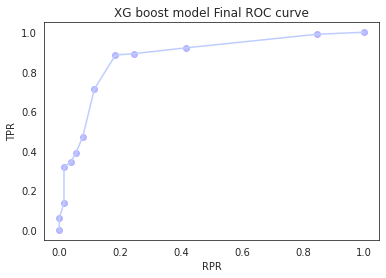

In [179]:
from sklearn.metrics import roc_curve

fpr3, tpr3, thresholds = roc_curve(y_test,y_pred_proba_final)

plt.scatter(fpr3,tpr3,color='#A0A0FF',alpha=0.7)
plt.plot(fpr3,tpr3,color='#BECDFF')
plt.title('XG boost model Final ROC curve')
plt.xlabel('RPR')
plt.ylabel('TPR')

## **10**. 최종 모델 해석

### SHAP

In [180]:
!pip install shap

     |████████████████████████████████| 371 kB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509250 sha256=76514302e6b65aec606f71f57739d2174a1220db28d166caa937e063615a8944
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [181]:
row=X_test.iloc[[1]]
row

,Category_Extra,Category_Health,Category_Infra_vehicle,Category_Tech,invest_pace_PE,invest_pace_Pre-IPO,invest_pace_Series A,invest_pace_Series B,invest_pace_Series C,invest_pace_prepare_startup
3331,0,0,0,1,0,0,0,0,0,1


In [182]:
import shap

In [183]:
model = XGBClassifier().fit(X_train, y_train)

In [184]:
explainer = shap.TreeExplainer(model)
shap_values= explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)
### Draw SHAP plots ###

In [185]:
''' invest_pace_SeriesA가 올리는데 근소한 역할을 하고, invest_pace_prepare_startup이 내리는 것에 큰 역할을 한다. 
본 데이터는 분류모델로 수치형은 없고, 카테고리항목들로 구성되어 있다. 위에 해당하는 row는 Tech 분야이고, startup을 준비하고 있는 단계에 있는 Pre-Seed나 Seed 단계에 있다.'''

' invest_pace_SeriesA가 올리는데 근소한 역할을 하고, invest_pace_prepare_startup이 내리는 것에 큰 역할을 한다. \n본 데이터는 분류모델로 수치형은 없고, 카테고리항목들로 구성되어 있다. 위에 해당하는 row는 Tech 분야이고, startup을 준비하고 있는 단계에 있는 Pre-Seed나 Seed 단계에 있다.'

In [186]:
row2=X_test.iloc[[2]]
row2

,Category_Extra,Category_Health,Category_Infra_vehicle,Category_Tech,invest_pace_PE,invest_pace_Pre-IPO,invest_pace_Series A,invest_pace_Series B,invest_pace_Series C,invest_pace_prepare_startup
2364,0,0,0,1,0,0,0,1,0,0


In [187]:
explainer = shap.TreeExplainer(model)
shap_values= explainer.shap_values(row2)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row2
)
### Draw SHAP plots ###

In [188]:
''' row1과 다르게 row2는 SeriesB에 속한다. SHAP의 결과를 보면, 해당 결과를 낯추는 역할을 하는 항목은 없고, 해당 결과를 높이는 항목들로 구성되어있다. 
가장 영향을 많이 끼친 항목은 Series B인 항목이고, 다음으로 스타트업을 준비하는 단계가 아닌 항목(prepare_startup)으로 pre-seed와 seed에 해당하는 영역,
마지막으로 영향을 많이 끼친 항목은 Series A가 아닌 항목이다. '''

' row1과 다르게 row2는 SeriesB에 속한다. SHAP의 결과를 보면, 해당 결과를 낯추는 역할을 하는 항목은 없고, 해당 결과를 높이는 항목들로 구성되어있다. \n가장 영향을 많이 끼친 항목은 Series B인 항목이고, 다음으로 스타트업을 준비하는 단계가 아닌 항목(prepare_startup)으로 pre-seed와 seed에 해당하는 영역,\n마지막으로 영향을 많이 끼친 항목은 Series A가 아닌 항목이다. '

In [189]:
row3=X_test.iloc[[3]]
row3

,Category_Extra,Category_Health,Category_Infra_vehicle,Category_Tech,invest_pace_PE,invest_pace_Pre-IPO,invest_pace_Series A,invest_pace_Series B,invest_pace_Series C,invest_pace_prepare_startup
2439,0,0,0,1,0,0,0,0,0,1


In [190]:
explainer = shap.TreeExplainer(model)
shap_values= explainer.shap_values(row3)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row3
)
### Draw SHAP plots ###

In [191]:
''' 세 번째 row 역시 Tech 카테고리에 속하는 데이터로, 스타트업을 준비하고 있는 단계에 있다. Pre-seed, 또는 seed에 속한다. 
아래 SHAP의 결과를 보면, 다음의 결과를 낮추는데 큰 역할을 한 스타트업을 준비하는 단계(prepare_startup=1)와 올리는 것에 근소한 역할을 한 Series A가 아닌 항목(Series A=0)인 항목이다. '''

' 세 번째 row 역시 Tech 카테고리에 속하는 데이터로, 스타트업을 준비하고 있는 단계에 있다. Pre-seed, 또는 seed에 속한다. \n아래 SHAP의 결과를 보면, 다음의 결과를 낮추는데 큰 역할을 한 스타트업을 준비하는 단계(prepare_startup=1)와 올리는 것에 근소한 역할을 한 Series A가 아닌 항목(Series A=0)인 항목이다. '

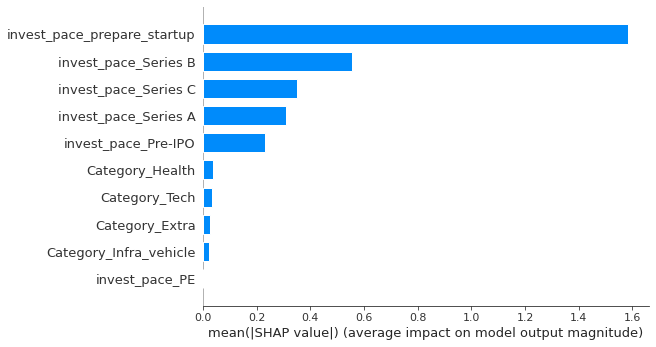

In [192]:
shap_values4 = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values4,X_test.iloc[:300],plot_type='bar')

In [193]:
model.feature_importances_

array([0.00247793, 0.00389001, 0.00128089, 0.00368171, 0.        ,
       0.00799597, 0.03313192, 0.02290322, 0.0249199 , 0.89971846],
      dtype=float32)

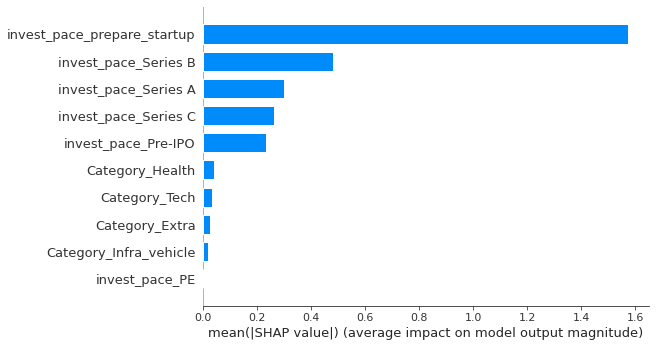

In [194]:
shap_values5 = explainer.shap_values(X_test.iloc[:])
shap.summary_plot(shap_values5,X_test.iloc[:],plot_type='bar')

### 예측된 항목 추가

In [195]:
test_id = X_test.index

In [196]:
# 예측함수 정의

predicted_df = pd.DataFrame({
              'pred_proba': y_pred_proba_final, # 예측확률 
              'status_group': y_test # 실제값
})

In [197]:
df3

,Company,Region,Field,Category,invest_pace,Domestic_Scaled
0,Internxt,Spain,Blockchain,Tech,prepare_startup,False
1,Internxt,Spain,Blockchain,Tech,prepare_startup,False
2,Factorial,Spain,B2B Software,Tech,Series A,True
3,ANYVERSE,Spain,Autonomous Vehicles,Infra_vehicle,Series A,False
4,Bloobirds,Spain,B2B Software,Tech,Series A,False
...,...,...,...,...,...,...
3555,MarketForce,Kenya,B2B Software,Tech,prepare_startup,False
3556,Crehana,Peru,Education,Infra_vehicle,Series B,True
3557,Tiki Corporation,Vietnam,Marketplace,Business,Pre-IPO,True
3558,Bloktopia,Isle of Man,Blockchain,Tech,prepare_startup,True


In [198]:
predicted_df

,pred_proba,status_group
2240,0.99,True
3331,0.39,False
2364,0.99,True
2439,0.39,False
18,0.99,True
...,...,...
2538,0.96,True
1022,1.00,True
576,0.96,True
1512,0.99,True


In [199]:
# 여기서부터 merge하자
predicted_df = pd.concat([df3,predicted_df],axis=1)

In [200]:
predicted_df=predicted_df.dropna(axis=0)
predicted_df

,Company,Region,Field,Category,invest_pace,Domestic_Scaled,pred_proba,status_group
4,Bloobirds,Spain,B2B Software,Tech,Series A,False,0.96,False
11,Gravity Wave,Spain,Wellness,Health,prepare_startup,False,0.31,False
15,Unnax,Spain,Finance,Business,Series B,True,1.00,True
18,Copado,Spain,Cloud Computing,Tech,Series B,True,0.99,True
20,Wallapop,Spain,Marketplace,Business,Pre-IPO,True,1.00,True
...,...,...,...,...,...,...,...,...
3545,Algramo,Chile,Consumer,Business,Series A,True,1.00,True
3546,Fintoc,Chile,Finance,Business,prepare_startup,True,0.42,True
3548,Fintual,Chile,Finance,Business,Series A,True,1.00,True
3549,Global 66,Chile,Finance,Business,Series A,True,1.00,True


### 예측된 항목 비교

예측이 잘 된 항목

In [201]:
condition = predicted_df['pred_proba']>=0.5
predicted_df[condition]

,Company,Region,Field,Category,invest_pace,Domestic_Scaled,pred_proba,status_group
4,Bloobirds,Spain,B2B Software,Tech,Series A,False,0.96,False
15,Unnax,Spain,Finance,Business,Series B,True,1.00,True
18,Copado,Spain,Cloud Computing,Tech,Series B,True,0.99,True
20,Wallapop,Spain,Marketplace,Business,Pre-IPO,True,1.00,True
23,CF Intercity,Spain,Education,Infra_vehicle,Series A,False,1.00,False
...,...,...,...,...,...,...,...,...
3543,Joyous,New Zealand,Human Resources,Business,Series A,True,1.00,True
3545,Algramo,Chile,Consumer,Business,Series A,True,1.00,True
3548,Fintual,Chile,Finance,Business,Series A,True,1.00,True
3549,Global 66,Chile,Finance,Business,Series A,True,1.00,True


예측이 잘 안 된 항목

In [202]:
condition2 = predicted_df['pred_proba']<0.5
predicted_df[condition2]

,Company,Region,Field,Category,invest_pace,Domestic_Scaled,pred_proba,status_group
11,Gravity Wave,Spain,Wellness,Health,prepare_startup,False,0.31,False
54,Datavillage,Belgium,Cyber Security,Tech,prepare_startup,False,0.39,False
63,api.video,France,Developer APIs,Tech,prepare_startup,False,0.39,False
91,Axorus,France,Neuroscience,Health,prepare_startup,False,0.31,False
101,Tchek,France,Artificial Intelligence,Tech,prepare_startup,True,0.39,True
...,...,...,...,...,...,...,...,...
3508,Mabaat,Saudi Arabia,Travel,Health,prepare_startup,False,0.31,False
3514,SadaPay,Pakistan,Finance,Business,prepare_startup,True,0.42,True
3515,Sehat Kahani,Pakistan,Health Care,Health,prepare_startup,False,0.31,False
3524,ZELF,Latvia,Finance,Business,prepare_startup,False,0.42,False


In [203]:
right_predicted = predicted_df[condition].shape[0]
wrong_predicted = predicted_df[condition2].shape[0]
right = right_predicted/(right_predicted+wrong_predicted)*100
wrong = wrong_predicted/(right_predicted+wrong_predicted)*100

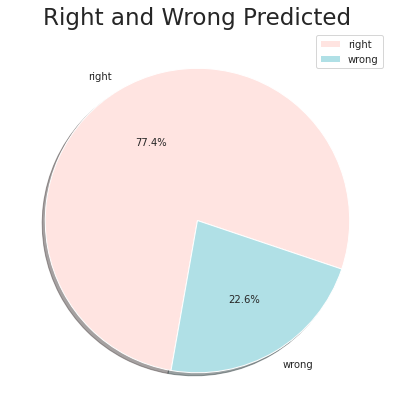

In [204]:
ratio = [right,wrong]
labels = ['right', 'wrong']
colors = ['#ffe4e1','#b0e0e6']
#plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, shadow=True, colors=colors)

fig5= plt.figure(figsize=(7,7))
fig5.add_subplot(1,1,1)
ax5=plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, shadow=True, colors=colors)
plt.title('Right and Wrong Predicted',fontsize=23)
# 레전드 달기
plt.legend(['right','wrong'], loc='upper right')

### 시행 착오 :)   # 위에 주의 사항 적을 때 참조

시작 전 시행 착오
- 프로젝트를 시작하기 전 모델의 방향성에 대한 시행착오를 겪음
- 필자는 프로젝트를 시작하기 전 Funding Amount의 일정 금액 이상을 recommend로 분류해주고자 했음
    - 그런데 문제점이 발생했는데, 이 데이터는 '투자 받은 company'를 대상으로 하고 있기 때문
    - 정확한 결과가 나오지 않을 것으로 판단하여 다른 방향성을 찾고자 함
    

## 기타

**+** 대한민국 카테고리 살펴보기

In [205]:
df_korea= df3[df3['Region'].str.contains('South Korea')] 
df_korea

,Company,Region,Field,Category,invest_pace,Domestic_Scaled
3129,Lunit,South Korea,Artificial Intelligence,Tech,Series C,True
3130,Bitsensing,South Korea,Autonomous Vehicles,Infra_vehicle,prepare_startup,True
3131,MakinaRocks,South Korea,Artificial Intelligence,Tech,Series A,True
3132,Xangle,South Korea,Blockchain,Tech,Series A,False
3133,Jandi,South Korea,B2B Software,Tech,Series B,True
3134,Lunit,South Korea,Artificial Intelligence,Tech,Series C,True
3135,Tridge,South Korea,Food and Beverage,Health,Series C,True
